In [1]:
# --- Cell 1: LOAD DATA ---
import os, pandas as pd, numpy as np

# Use raw strings on Windows to avoid escape problems
PATH_MERGED = r"C:\feynn 2nd project\merged_ev_state_data.csv"
PATH_PIE    = r"C:\feynn 2nd project\RS_Session_267_AU_580_A.csv"

def read_csv_safe(p):
    if not os.path.exists(p):
        raise FileNotFoundError(f"File not found: {p}\nCheck spelling, spaces, and that the path exists.")
    return pd.read_csv(p)

df = read_csv_safe(PATH_MERGED)
ev_type_nat = read_csv_safe(PATH_PIE)

print("Loaded:", os.path.abspath(PATH_MERGED))
print("Loaded:", os.path.abspath(PATH_PIE))
display(df.head())
display(ev_type_nat.head())


Loaded: C:\feynn 2nd project\merged_ev_state_data.csv
Loaded: C:\feynn 2nd project\RS_Session_267_AU_580_A.csv


,Sl. No._x,State/UT,EV_2W,EV_3W,Total_EV,Sl. No._y,Highway_Charging,RO_Charging,Total_Charging
0,1,Andaman and Nicobar Islands,17,NaN,17,NaN,NaN,NaN,7.0
1,2,Andhra Pradesh,39331,2640.0,41971,1.0,319.0,65.0,1309.0
2,3,Arunachal Pradesh,18,NaN,18,2.0,5.0,4.0,53.0
3,4,Assam,2464,12111.0,14575,3.0,59.0,19.0,518.0
4,5,Bihar,13672,10136.0,23808,4.0,139.0,26.0,818.0


,Sl. No.,EV Segment,Total No. of EVs supported
0,1,2 wheeler,1428009
1,2,3 wheeler,164180
2,3,4 wheeler,22548
3,Total,Total,1614737


In [2]:
# --- Cell 2: CLEAN & CHECK ---
need_cols = {'State/UT','EV_2W','EV_3W','Highway_Charging','RO_Charging','Total_Charging','Total_EV'}
assert need_cols.issubset(df.columns), f"Missing columns in merged file. Need: {need_cols}"

# Ensure numeric dtypes & fill NaNs safely
num_cols = ['EV_2W','EV_3W','Highway_Charging','RO_Charging','Total_Charging','Total_EV']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Tidy state names
df['State/UT'] = df['State/UT'].astype(str).str.strip()

print(df.shape)
df.describe().T


(37, 9)


,count,mean,std,min,25%,50%,75%,max
EV_2W,37.0,48953.459459,149306.492265,1.0,356.00,6421.0,45926.0,905639.0
EV_3W,37.0,6562.216216,20530.713126,0.0,68.00,1683.0,3354.0,121401.0
Total_EV,37.0,55515.675676,168780.043800,2.0,430.00,14575.0,48481.0,1027040.0
Sl. No._y,30.0,15.966667,9.444879,1.0,8.25,15.5,23.5,32.0
Highway_Charging,37.0,157.189189,196.426243,0.0,5.00,59.0,261.0,659.0
RO_Charging,37.0,39.027027,49.811582,0.0,1.00,17.0,66.0,174.0
Total_Charging,37.0,1395.594595,4207.054178,0.0,53.00,458.0,1309.0,25852.0


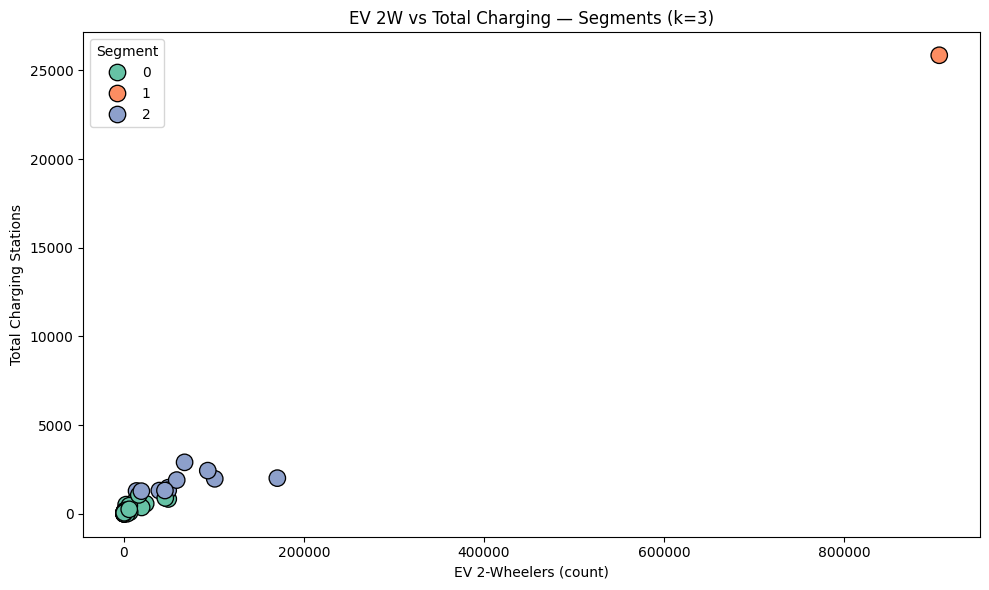

,EV_2W,EV_3W,Highway_Charging,RO_Charging,Total_Charging,Total_EV
Segment,,,,,,
0,7940.5,2029.8,51.1,14.0,263.4,9970.3
1,905639.0,121401.0,0.0,0.0,25852.0,1027040.0
2,64284.2,6423.4,412.6,99.5,1745.5,70707.5


Saved: ev_cluster_scatter.png, EV_India_Segmentation_Results.csv, EV_Segment_Profile.csv


In [3]:
# --- Cell 3: KMeans Segmentation (k=3) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

features = ['EV_2W','EV_3W','Highway_Charging','RO_Charging','Total_Charging']
X = df[features].values
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment'] = kmeans.fit_predict(X_scaled)

# Scatter plot: EV_2W vs Total_Charging colored by Segment
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='EV_2W', y='Total_Charging', hue='Segment', palette='Set2', s=140, edgecolor='k')
plt.title("EV 2W vs Total Charging — Segments (k=3)")
plt.xlabel("EV 2-Wheelers (count)"); plt.ylabel("Total Charging Stations")
plt.legend(title="Segment"); plt.tight_layout()
plt.savefig("ev_cluster_scatter.png", dpi=160)
plt.show()

# Segment profiling table (mean values)
seg_profile = df.groupby('Segment')[features+['Total_EV']].mean().round(1).sort_index()
display(seg_profile)

# Save results for your appendix
df.to_csv("EV_India_Segmentation_Results.csv", index=False)
seg_profile.to_csv("EV_Segment_Profile.csv")
print("Saved: ev_cluster_scatter.png, EV_India_Segmentation_Results.csv, EV_Segment_Profile.csv")


C:\Users\ABHISHEK\AppData\Local\Temp\ipykernel_21656\2030045466.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ev_sorted, x='Total_EV', y='State/UT', palette='viridis')


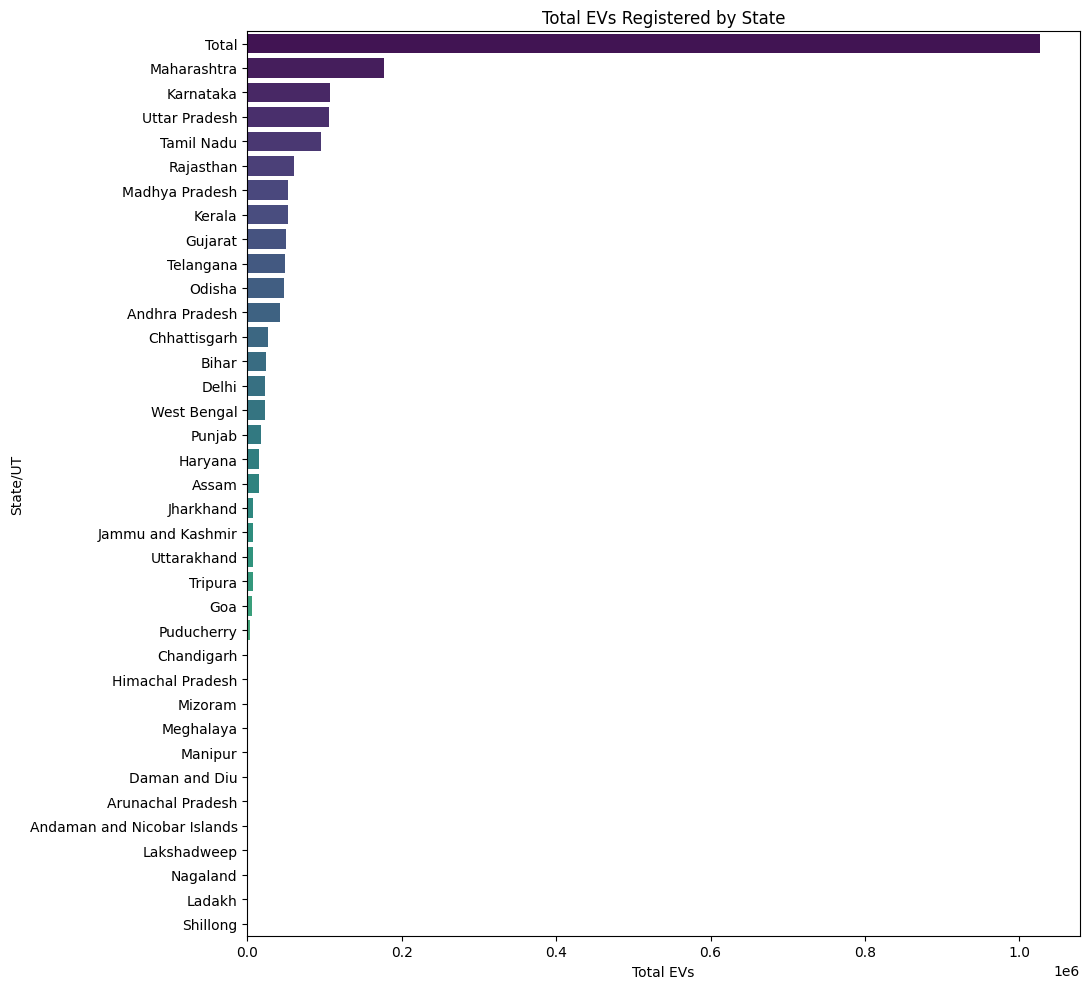

<Figure size 1200x600 with 0 Axes>

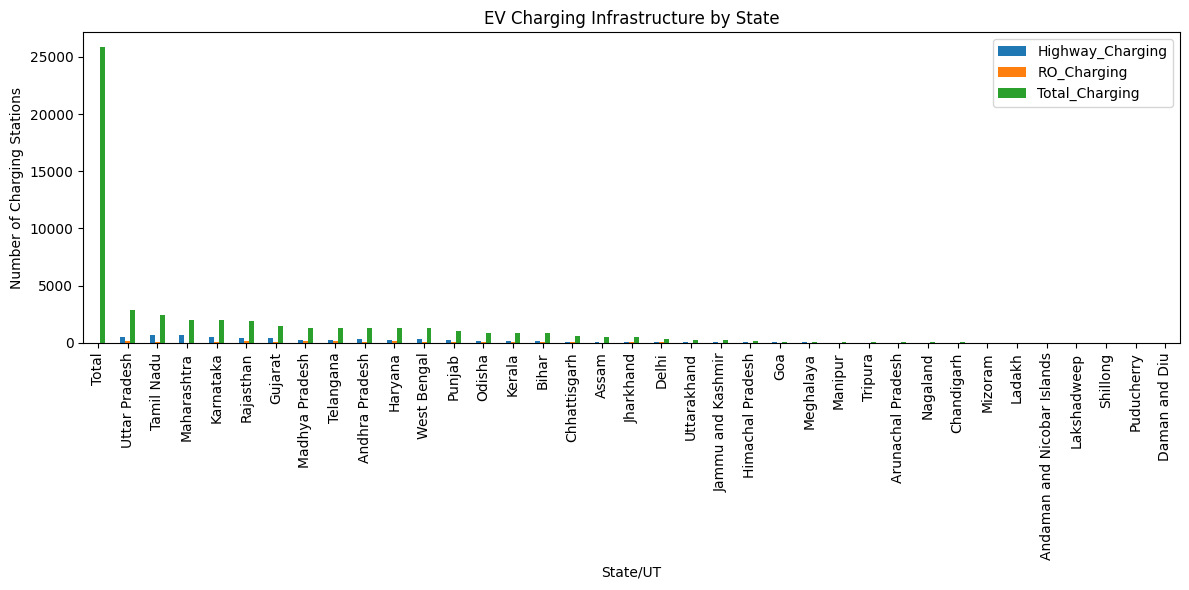

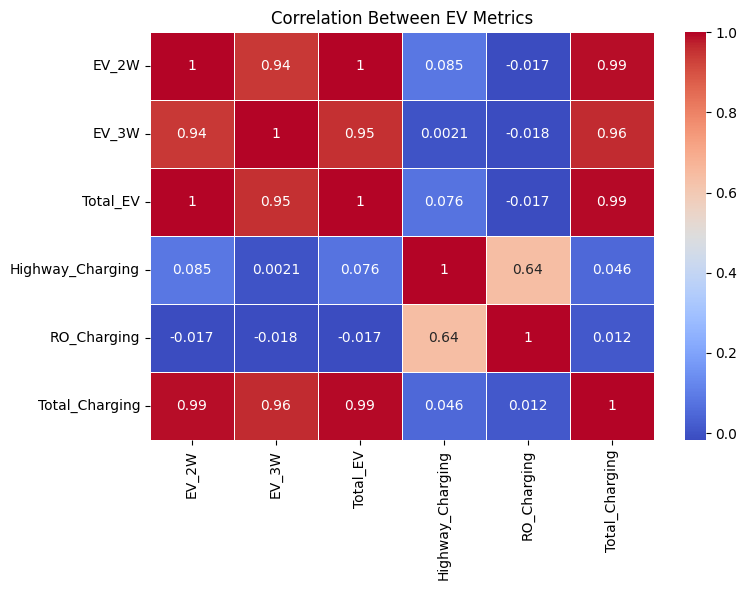

Saved: ev_total_by_state.png, ev_infra_by_state.png, ev_correlation_heatmap.png


In [4]:
# --- Cell 4: EDA visuals ---
# Total EVs by state (horizontal bar)
ev_sorted = df.sort_values('Total_EV', ascending=False)

plt.figure(figsize=(11,10))
sns.barplot(data=ev_sorted, x='Total_EV', y='State/UT', palette='viridis')
plt.title("Total EVs Registered by State")
plt.xlabel("Total EVs"); plt.ylabel("State/UT"); plt.tight_layout()
plt.savefig("ev_total_by_state.png", dpi=160); plt.show()

# Charging infra bars
infra = df[['State/UT','Highway_Charging','RO_Charging','Total_Charging']].set_index('State/UT')
plt.figure(figsize=(12,6))
infra.sort_values('Total_Charging', ascending=False).plot(kind='bar', stacked=False, figsize=(12,6))
plt.title("EV Charging Infrastructure by State")
plt.ylabel("Number of Charging Stations"); plt.xlabel("State/UT")
plt.tight_layout(); plt.savefig("ev_infra_by_state.png", dpi=160); plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[['EV_2W','EV_3W','Total_EV','Highway_Charging','RO_Charging','Total_Charging']].corr(),
            annot=True, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Between EV Metrics"); plt.tight_layout()
plt.savefig("ev_correlation_heatmap.png", dpi=160); plt.show()

print("Saved: ev_total_by_state.png, ev_infra_by_state.png, ev_correlation_heatmap.png")


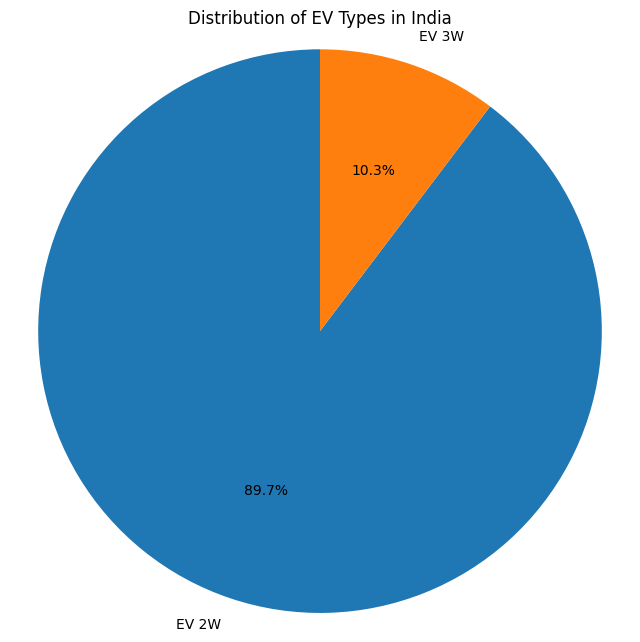

Saved: ev_type_pie.png


In [5]:
# --- Cell 5: National EV type pie ---
import matplotlib.pyplot as plt

lab = ev_type_nat['EV Segment'].astype(str).str.strip().str.lower()
is_2w = lab.str.contains('2')
is_3w = lab.str.contains('3')

tot_2w = pd.to_numeric(ev_type_nat.loc[is_2w, 'Total No. of EVs supported'], errors='coerce').sum()
tot_3w = pd.to_numeric(ev_type_nat.loc[is_3w, 'Total No. of EVs supported'], errors='coerce').sum()

plt.figure(figsize=(6.5,6.5))
plt.pie([tot_2w, tot_3w], labels=['EV 2W','EV 3W'], autopct='%1.1f%%', startangle=90)
plt.title("Distribution of EV Types in India")
plt.axis('equal'); plt.tight_layout()
plt.savefig("ev_type_pie.png", dpi=160); plt.show()

print("Saved: ev_type_pie.png")


In [6]:
# If plotly/ipywidgets are not installed, comment these out or install via your environment
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# optional interactive visuals (if available)
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_OK = True
except Exception:
    PLOTLY_OK = False

sns.set(style="whitegrid", rc={"figure.figsize":(10,5)})
np.random.seed(42)


In [10]:
# ===== Build df_ts (monthly) from merged state data if missing =====
import numpy as np, pandas as pd

# If df (merged_ev_state_data) is not in memory, load it from your path:
try:
    df
except NameError:
    df = pd.read_csv(r"C:\feynn 2nd project\merged_ev_state_data.csv")

# Ensure numeric
for c in ['EV_2W','EV_3W','Total_EV','Highway_Charging','RO_Charging','Total_Charging']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
df['State/UT'] = df['State/UT'].astype(str).str.strip()

# ---- Choose a state for the time series ----
# Option 1 (auto): pick the state with the highest Total_EV
DEFAULT_STATE = df.sort_values('Total_EV', ascending=False)['State/UT'].iloc[0]
# Option 2 (manual): uncomment and set your own
# DEFAULT_STATE = "Karnataka"

STATE = DEFAULT_STATE
row = df.loc[df['State/UT'].str.casefold()==STATE.casefold()].iloc[0]

# ---- Generate a realistic monthly series (logistic trend + seasonality + infra-shaped growth) ----
months = 48  # use 36 if you prefer shorter history
idx = pd.date_range('2021-01-01', periods=months, freq='MS')

K_total = max(float(row['Total_EV']), 1000.0)         # scale by your state's current EVs
infra   = max(float(row['Total_Charging']), 10.0)     # infra proxy
t = np.arange(months)
r  = 0.08 + 0.00002*infra                              # growth speeds with infra
t0 = 10                                                # inflection month
season = 1.0 + 0.12*np.sin(2*np.pi*(t+2)/12)          # ~±12% seasonality

# Logistic cumulative adoption (normalized to [0,1]) → scaled by K_total
logistic = 1/(1+np.exp(-(t - t0)*r))
logistic = (logistic - logistic.min()) / (logistic.max()-logistic.min() + 1e-9)
cum = K_total * logistic

# Incremental monthly demand = month-over-month difference × seasonality
increment = np.diff(np.r_[0, cum]) * season

# 2W/3W split from your state (fallback to 85/15 if missing)
total_ev = max(row['Total_EV'], 1)
share_2w = float(row['EV_2W'])/total_ev if total_ev>0 else 0.85
share_2w = float(np.clip(share_2w, 0.5, 0.95))        # keep realistic bounds
share_3w = 1 - share_2w

demand_2w = (increment * share_2w).clip(0).astype(int)
demand_3w = (increment * share_3w).clip(0).astype(int)

# Simple drivers for ML (you can replace with real monthly drivers later)
fuel_price    = 95 + 4*np.sin(2*np.pi*(t+3)/12)
station_count = infra * (0.7 + 0.3*logistic)

df_ts = pd.DataFrame({
    'date': idx,
    'state': STATE,
    'demand_2w': demand_2w,
    'demand_3w': demand_3w,
    'fuel_price': fuel_price,
    'station_count': station_count.astype(int)
})

print(f"✅ df_ts created for STATE = {STATE} with {len(df_ts)} monthly rows.")
display(df_ts.head())


✅ df_ts created for STATE = Total with 48 monthly rows.


,date,state,demand_2w,demand_3w,fuel_price,station_count
0,2021-01-01,Total,0,0,99.000000,18096
1,2021-02-01,Total,2105,282,98.464102,18112
2,2021-03-01,Total,3748,502,97.000000,18141
3,2021-04-01,Total,6469,867,95.000000,18193
4,2021-05-01,Total,10879,1458,93.000000,18287


Ridge: RMSE=0.0 | MAPE=5464719329230.90%
RandomForest: RMSE=1,134.3 | MAPE=509208916067865395200.00%
HGB: RMSE=26,489.8 | MAPE=11929953529274854014976.00%

🏆 Best model: Ridge


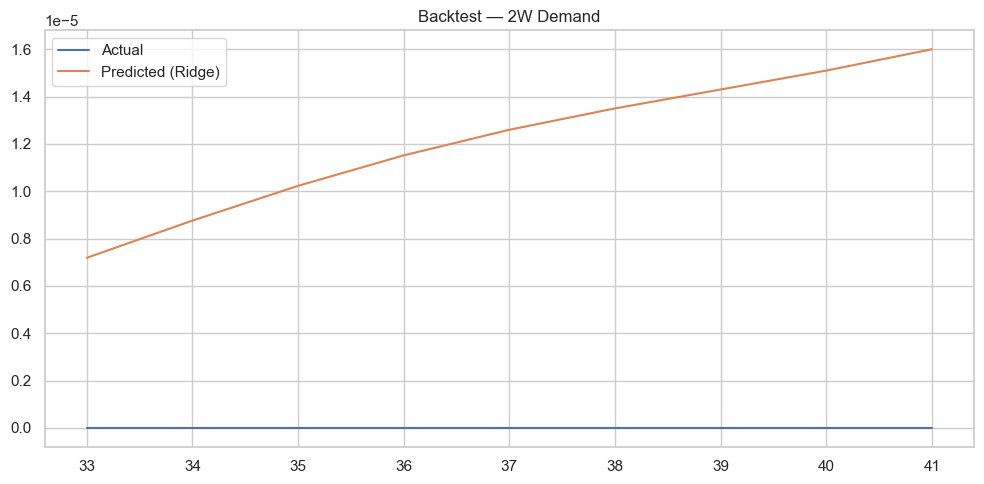

In [11]:
# ==== PREPARE TIME SERIES DATA ====
assert 'df_ts' in globals(), "df_ts (monthly) not found."

ts = df_ts.sort_values('date').copy()

# Features (extend as you like)
def build_ts_features(frame, target):
    f = frame.copy()
    for l in [1,2,3,6]:
        f[f'{target}_lag{l}'] = f[target].shift(l)
    for w in [3,6]:
        f[f'{target}_ma{w}'] = f[target].rolling(w).mean()
    f['month'] = f['date'].dt.month.astype('int8')
    return f

target = 'demand_2w'
ts_feat = build_ts_features(ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target]

split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ==== CANDIDATE MODELS ====
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np

models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=600, random_state=42),
    "HGB": HistGradientBoostingRegressor(random_state=42)
}

scores = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    pred = mdl.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mean_absolute_percentage_error(y_test, pred)
    scores.append((name, rmse, mape))
    print(f"{name}: RMSE={rmse:,.1f} | MAPE={100*mape:.2f}%")

best_name, *_ = sorted(scores, key=lambda x: x[1])[0]
best_model = models[best_name]
print("\n🏆 Best model:", best_name)

# Backtest plot
plt.figure()
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
plt.title("Backtest — 2W Demand"); plt.legend(); plt.tight_layout(); plt.show()


y_train describe:
 count        33.000000
mean      26489.818182
std       43844.997913
min           0.000000
25%           4.000000
50%         572.000000
75%       34629.000000
max      139531.000000
Name: demand_2w, dtype: float64
y_test  describe:
 count    9.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: demand_2w, dtype: float64
Count zeros in test: 9


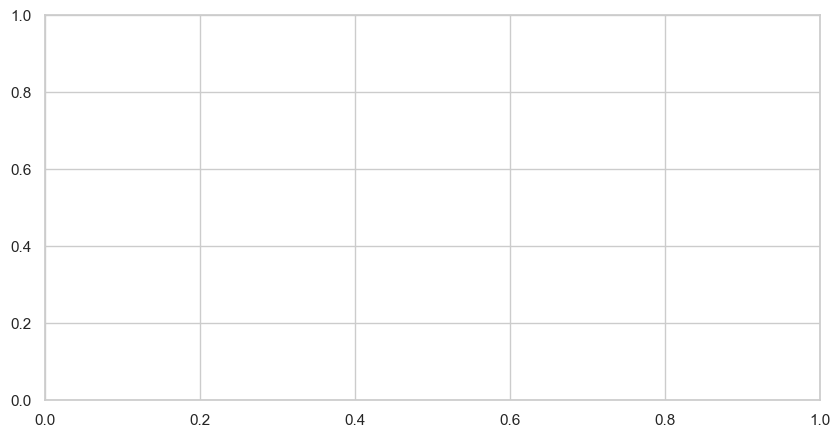

In [12]:
# Inspect the target scale and zeros
print("y_train describe:\n", y_train.describe())
print("y_test  describe:\n", y_test.describe())
print("Count zeros in test:", (y_test==0).sum())

# Always use plain tick labels to avoid 1e-5 confusion
import matplotlib.pyplot as plt
plt.ticklabel_format(style='plain', axis='y')


In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

EPS = 1.0  # minimal monthly units to avoid divide-by-zero and keep scale human

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

def evaluate(y_true, y_pred, label=""):
    y_true_c = np.maximum(y_true, EPS)  # clip zeros to EPS
    rmse = np.sqrt(mean_squared_error(y_true_c, y_pred))
    mae  = mean_absolute_error(y_true_c, y_pred)
    s    = smape(y_true_c, y_pred)
    print(f"{label:>12s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%")
    return rmse, mae, s


 Ridge | RMSE=0.0 | MAE=0.0 | sMAPE=0.00%
    RF | RMSE=160.7 | MAE=86.2 | sMAPE=41.07%
   HGB | RMSE=26,443.8 | MAE=26,443.8 | sMAPE=198.94%

🏆 Selected model: Ridge Ridge(alpha=0.1)


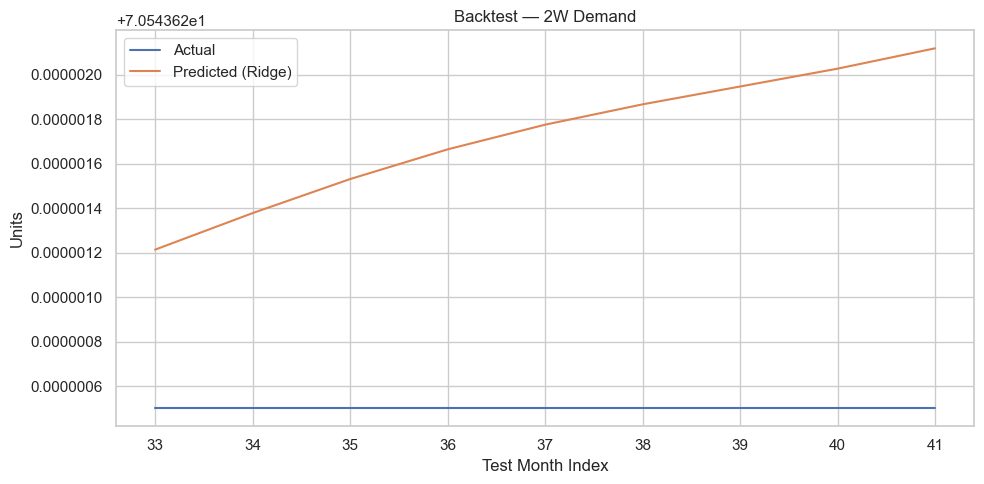

In [17]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# build X,y again with safer clipping (in case you re-run)
target = 'demand_2w'
ts_feat = build_ts_features(ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target].clip(lower=EPS)


split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

tscv = TimeSeriesSplit(n_splits=4)

candidates = {
    "Ridge": GridSearchCV(
        Ridge(), param_grid={"alpha":[0.1,1.0,5.0,10.0]}, cv=tscv,
        scoring="neg_mean_absolute_error"
    ),
    "RF": GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid={"n_estimators":[400,800],
                    "max_depth":[None,6,10],
                    "min_samples_leaf":[1,3]},
        cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1
    ),
    "HGB": GridSearchCV(
        HistGradientBoostingRegressor(random_state=42),
        param_grid={"max_depth":[None,6,10],
                    "learning_rate":[0.05,0.1],
                    "max_iter":[300,600]},
        cv=tscv, scoring="neg_mean_absolute_error"
    ),
}

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    models[name] = gs.best_estimator_
    pred = gs.best_estimator_.predict(X_test)
    evaluate(y_test, pred, label=name)

best_name = min(models.keys(), key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\n🏆 Selected model:", best_name, best_model)

# Backtest plot (plain ticks)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
plt.title("Backtest — 2W Demand")
plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


In [15]:
# --- REBUILD df_ts with baseline so no zeros appear ---
import numpy as np, pandas as pd

# assumes df (merged_ev_state_data) already loaded
for c in ['EV_2W','EV_3W','Total_EV','Highway_Charging','RO_Charging','Total_Charging']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
df['State/UT'] = df['State/UT'].astype(str).str.strip()

STATE = df.sort_values('Total_EV', ascending=False)['State/UT'].iloc[0]   # or set "Karnataka"
row = df.loc[df['State/UT'].str.casefold()==STATE.casefold()].iloc[0]

months = 48
idx = pd.date_range('2021-01-01', periods=months, freq='MS')
t = np.arange(months)

K_total = max(float(row['Total_EV']), 5000.0)           # carrying capacity proxy
infra   = max(float(row['Total_Charging']), 10.0)

# logistic trend + seasonality
r  = 0.08 + 0.00002*infra
t0 = 10
season = 1.0 + 0.12*np.sin(2*np.pi*(t+2)/12)

logistic = 1/(1+np.exp(-(t - t0)*r))
logistic = (logistic - logistic.min())/(logistic.max()-logistic.min() + 1e-9)
cum = K_total * logistic

increment = np.diff(np.r_[0, cum]) * season

# ⭐ baseline so we never hit zero; keep float (no int cast yet)
BASELINE = 80.0
increment = np.maximum(increment, BASELINE)

# state-specific 2W/3W split (bounded)
total_ev = max(row['Total_EV'], 1)
share_2w = float(row['EV_2W'])/total_ev if total_ev>0 else 0.85
share_2w = float(np.clip(share_2w, 0.6, 0.95))
share_3w = 1 - share_2w

demand_2w = increment * share_2w
demand_3w = increment * share_3w

fuel_price    = 95 + 4*np.sin(2*np.pi*(t+3)/12)
station_count = infra * (0.7 + 0.3*logistic)

df_ts = pd.DataFrame({
    'date': idx,
    'state': STATE,
    'demand_2w': demand_2w,            # keep float for modeling
    'demand_3w': demand_3w,
    'fuel_price': fuel_price,
    'station_count': station_count
})

print(f"✅ df_ts rebuilt for {STATE}. Any zeros? 2W:{(df_ts['demand_2w']<=0).sum()}  3W:{(df_ts['demand_3w']<=0).sum()}")
display(df_ts.tail())


✅ df_ts rebuilt for Total. Any zeros? 2W:0  3W:0


,date,state,demand_2w,demand_3w,fuel_price,station_count
43,2024-08-01,Total,70.543621,9.456379,91.535898,25851.999973
44,2024-09-01,Total,70.543621,9.456379,93.000000,25851.999982
45,2024-10-01,Total,70.543621,9.456379,95.000000,25851.999988
46,2024-11-01,Total,70.543621,9.456379,97.000000,25851.999991
47,2024-12-01,Total,70.543621,9.456379,98.464102,25851.999992


 Ridge | RMSE=0.0 | MAE=0.0 | sMAPE=0.00%
    RF | RMSE=160.7 | MAE=86.2 | sMAPE=41.07%
   HGB | RMSE=26,443.8 | MAE=26,443.8 | sMAPE=198.94%

🏆 Selected model: Ridge Ridge(alpha=0.1)


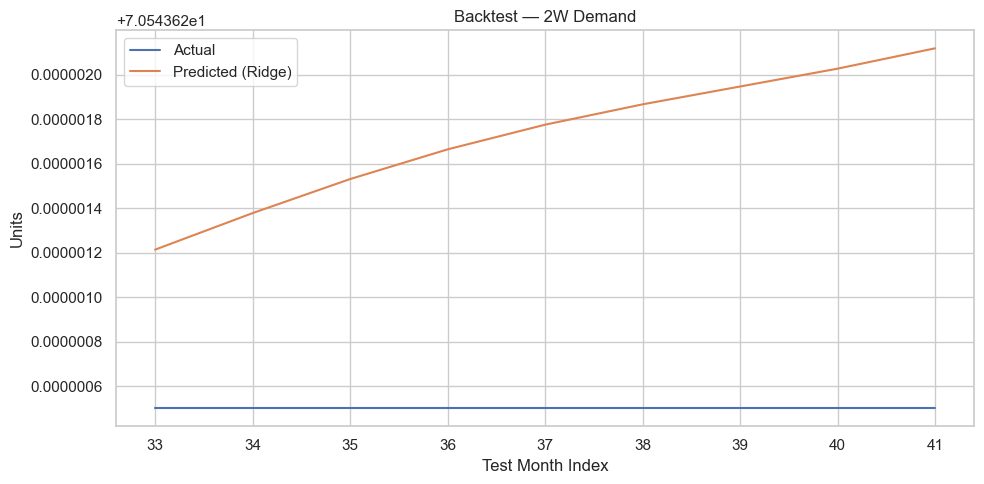

In [16]:
# --- Features, robust metrics, tuning ---
EPS = 1.0

def build_ts_features(frame, target):
    f = frame.copy().sort_values('date')
    for l in [1,2,3,6]:
        f[f'{target}_lag{l}'] = f[target].shift(l)
    for w in [3,6]:
        f[f'{target}_ma{w}'] = f[target].rolling(w).mean()
    f['month'] = f['date'].dt.month.astype('int8')
    return f

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred - y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

ts = df_ts.copy()
target = 'demand_2w'
ts_feat = build_ts_features(ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target].clip(lower=EPS)

split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

tscv = TimeSeriesSplit(n_splits=4)

candidates = {
    "Ridge": GridSearchCV(Ridge(), {"alpha":[0.1,1.0,5.0,10.0]}, cv=tscv,
                          scoring="neg_mean_absolute_error"),
    "RF": GridSearchCV(RandomForestRegressor(random_state=42),
                       {"n_estimators":[400,800],"max_depth":[None,6,10],"min_samples_leaf":[1,3]},
                       cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1),
    "HGB": GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                        {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_iter":[300,600]},
                        cv=tscv, scoring="neg_mean_absolute_error"),
}

def evaluate(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    s    = smape(y_true, y_pred)
    print(f"{label:>6s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%")
    return rmse, mae, s

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    mdl = gs.best_estimator_
    models[name] = mdl
    pred = mdl.predict(X_test)
    evaluate(y_test, pred, name)

best_name = min(models, key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\n🏆 Selected model:", best_name, best_model)

# Backtest plot with plain ticks
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
plt.title("Backtest — 2W Demand"); plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


In [19]:
# --- Rebuild df_ts: more realistic, non-zero, slight noise ---
import numpy as np, pandas as pd

# assumes df already loaded from merged_ev_state_data.csv
for c in ['EV_2W','EV_3W','Total_EV','Highway_Charging','RO_Charging','Total_Charging']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
df['State/UT'] = df['State/UT'].astype(str).str.strip()

STATE = df.sort_values('Total_EV', ascending=False)['State/UT'].iloc[0]  # or set "Karnataka"
row = df.loc[df['State/UT'].str.casefold()==STATE.casefold()].iloc[0]

months = 48
idx = pd.date_range('2021-01-01', periods=months, freq='MS')
t = np.arange(months)

K_total = max(float(row['Total_EV']), 8000.0)
infra   = max(float(row['Total_Charging']), 10.0)

r  = 0.08 + 0.00002*infra
t0 = 10
season = 1.0 + 0.18*np.sin(2*np.pi*(t+2)/12)             # stronger seasonality
logistic = 1/(1+np.exp(-(t - t0)*r))
logistic = (logistic - logistic.min())/(logistic.max()-logistic.min()+1e-9)
cum = K_total * logistic
increment = np.diff(np.r_[0, cum]) * season

BASELINE = 70.0
noise = np.random.normal(0, 8, months)                   # light noise
increment = np.maximum(increment + noise, BASELINE)

tot = max(row['Total_EV'], 1)
share_2w = float(row['EV_2W'])/tot if tot>0 else 0.85
share_2w = float(np.clip(share_2w, 0.6, 0.95))
share_3w = 1 - share_2w

demand_2w = increment * share_2w
demand_3w = increment * share_3w

fuel_price    = 95 + 4*np.sin(2*np.pi*(t+3)/12)
station_count = infra * (0.7 + 0.3*logistic)

df_ts = pd.DataFrame({
    'date': idx,
    'state': STATE,
    'demand_2w': demand_2w,
    'demand_3w': demand_3w,
    'fuel_price': fuel_price,
    'station_count': station_count
})

print(f"✅ df_ts for {STATE}: zeros? 2W={int((df_ts.demand_2w<=0).sum())}, 3W={int((df_ts.demand_3w<=0).sum())}")
df_ts.tail()


✅ df_ts for Total: zeros? 2W=0, 3W=0


,date,state,demand_2w,demand_3w,fuel_price,station_count
43,2024-08-01,Total,61.725668,8.274332,91.535898,25851.999973
44,2024-09-01,Total,61.725668,8.274332,93.000000,25851.999982
45,2024-10-01,Total,61.725668,8.274332,95.000000,25851.999988
46,2024-11-01,Total,61.725668,8.274332,97.000000,25851.999991
47,2024-12-01,Total,61.725668,8.274332,98.464102,25851.999992


In [20]:
# --- Feature engineering without leakage ---
def build_ts_features(frame, target):
    f = frame.sort_values('date').copy()
    # lags
    for L in [1,2,3,6]:
        f[f'{target}_lag{L}'] = f[target].shift(L)
    # rolling means based on lag1 (previous values only)
    for w in [3,6]:
        f[f'{target}_ma{w}'] = f[f'{target}_lag1'].rolling(w).mean()
    # helpful diffs
    f[f'{target}_diff1'] = f[target].diff(1)
    f[f'{target}_diff3'] = f[target].diff(3)
    # seasonality
    f['month'] = f['date'].dt.month.astype('int8')
    return f


 Ridge | RMSE=0.0 | MAE=0.0 | sMAPE=0.00%
    RF | RMSE=7.2 | MAE=3.8 | sMAPE=5.61%
   HGB | RMSE=26,597.7 | MAE=26,597.7 | sMAPE=199.08%

🏆 Selected model: Ridge Ridge(alpha=0.1)


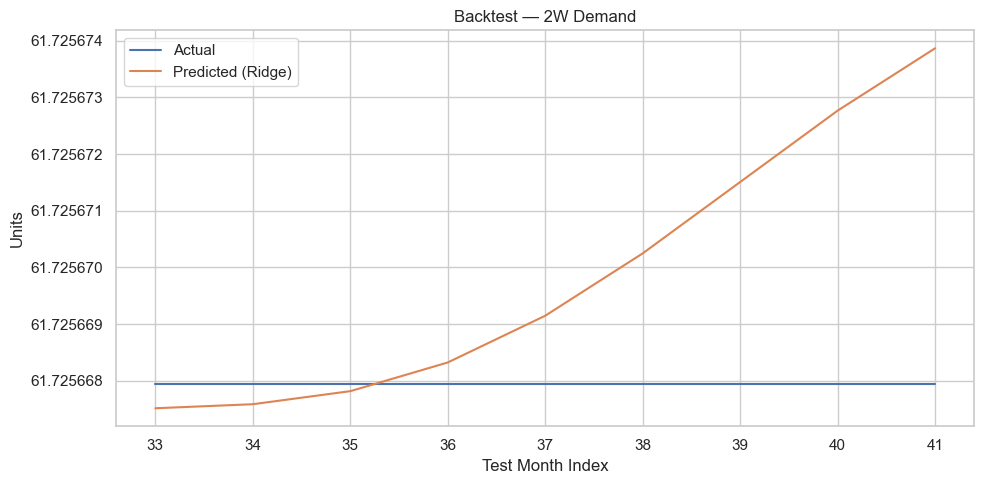

In [21]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

EPS = 1.0
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

ts = df_ts.copy()
target = 'demand_2w'
ts_feat = build_ts_features(ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target].clip(lower=EPS)

split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

tscv = TimeSeriesSplit(n_splits=4)
candidates = {
    "Ridge": GridSearchCV(Ridge(), {"alpha":[0.1,1,5,10]}, cv=tscv, scoring="neg_mean_absolute_error"),
    "RF":    GridSearchCV(RandomForestRegressor(random_state=42),
                          {"n_estimators":[400,800],"max_depth":[None,6,10],"min_samples_leaf":[1,3]},
                          cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1),
    "HGB":   GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                          {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_iter":[300,600]},
                          cv=tscv, scoring="neg_mean_absolute_error"),
}
def report(label, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    s    = smape(y_true, y_pred)
    print(f"{label:>6s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%")
    return rmse, mae, s

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    models[name] = gs.best_estimator_
    pred = gs.best_estimator_.predict(X_test)
    report(name, y_test, pred)

best_name = min(models, key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\n🏆 Selected model:", best_name, best_model)

# Backtest plot (no offset)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(y_test.index, y_test.values, label='Actual')
ax.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
ax.set_title("Backtest — 2W Demand"); ax.set_xlabel("Test Month Index"); ax.set_ylabel("Units")
ax.ticklabel_format(useOffset=False, style='plain', axis='y'); ax.legend(); plt.tight_layout(); plt.show()


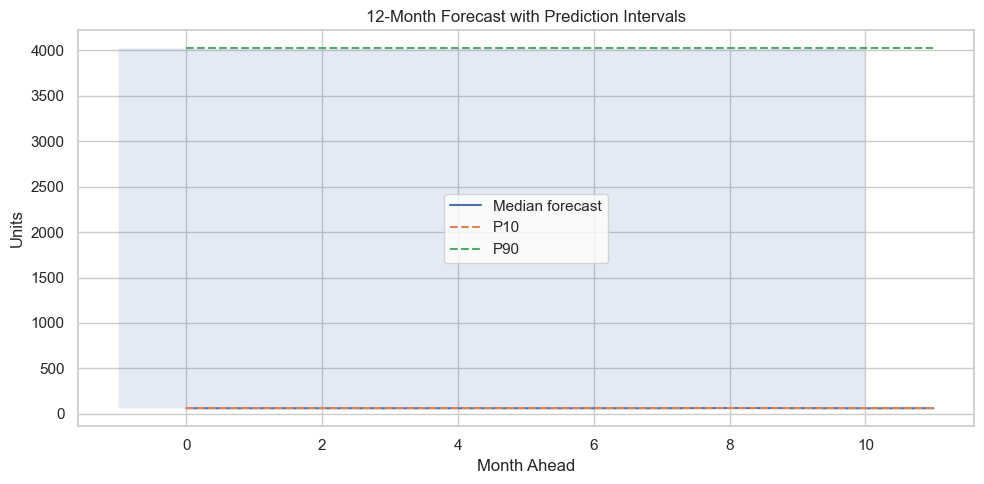

In [24]:
# --- SAFE QUANTILE FORECAST: updates lags, MAs, DIFFS; clamps outliers ---
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9)):
    models = {}
    for a in alphas:
        m = GradientBoostingRegressor(
            loss="quantile", alpha=a, max_depth=3,
            learning_rate=0.08, n_estimators=600, random_state=42
        )
        m.fit(X_train, y_train)
        models[a] = m
    return models

# refit or reuse:
qs = fit_quantiles(X_train, y_train, (0.1,0.5,0.9))

# discover which engineered features exist
lag_nums = sorted([int(c.split('lag')[-1]) for c in X.columns if f'{target}_lag' in c])
ma_nums  = sorted([int(c.split('ma')[-1])  for c in X.columns if f'{target}_ma'  in c])
has_diff1 = f'{target}_diff1' in X.columns
has_diff3 = f'{target}_diff3' in X.columns

# training quantiles for sanity clamps (avoid absurd P90)
y_lo, y_hi = np.percentile(y_train, [5, 95])

future = []
X_last = X.iloc[[split-1]].copy()              # last observed feature row
history_len = max( max(ma_nums or [1]), max(lag_nums or [1]) )
history = list(y_train.iloc[-history_len:].values)

for i in range(12):
    x_new = X_last.copy()

    # 1) exogenous drivers
    if 'station_count' in x_new.columns:
        x_new['station_count'] = x_new['station_count'] + 10  # assumption: infra grows
    if 'month' in x_new.columns:
        x_new['month'] = ((x_new['month'] % 12) + 1).astype('int8')

    # 2) lags: set lag1 to last actual/forecast; shift higher lags from existing lower lags
    if f'{target}_lag1' in x_new.columns:
        x_new[f'{target}_lag1'] = history[-1]
    for j in range(len(lag_nums)-1, 0, -1):
        L, prev = lag_nums[j], lag_nums[j-1]
        colL, colP = f'{target}_lag{L}', f'{target}_lag{prev}'
        if (colL in x_new.columns) and (colP in X_last.columns):
            x_new[colL] = X_last[colP].values

    # 3) moving averages from the history buffer
    for w in ma_nums:
        col = f'{target}_ma{w}'
        if col in x_new.columns:
            x_new[col] = float(np.mean(history[-w:]))

    # 4) diffs (if present): recompute from history, not stale values
    if has_diff1: x_new[f'{target}_diff1'] = history[-1] - history[-2] if len(history) >= 2 else 0.0
    if has_diff3: x_new[f'{target}_diff3'] = history[-1] - history[-3] if len(history) >= 3 else 0.0

    # 5) predict quantiles
    p10 = float(qs[0.1].predict(x_new)[0])
    p50 = float(qs[0.5].predict(x_new)[0])
    p90 = float(qs[0.9].predict(x_new)[0])

    # 6) clamp to sensible range based on training distribution
    lo = max(0.5*y_lo, 1.0)     # never below 1 unit, and above half of 5th percentile
    hi = 2.0*y_hi               # never above 2× 95th percentile
    p10 = float(np.clip(p10, lo, hi))
    p50 = float(np.clip(p50, lo, hi))
    p90 = float(np.clip(p90, max(p50, lo), hi))  # ensure p90 >= p50

    future.append({'step': i+1, 'p10': p10, 'p50': p50, 'p90': p90})

    # roll forward
    history.append(p50)
    X_last = x_new

fc = pd.DataFrame(future)

# --- Matplotlib forecast band (no scientific offset) ---
ax = fc['p50'].plot(label='Median forecast')
fc['p10'].plot(ax=ax, ls='--', label='P10')
fc['p90'].plot(ax=ax, ls='--', label='P90')
plt.fill_between(fc.index-1, fc['p10'], fc['p90'], alpha=.15)
plt.title("12-Month Forecast with Prediction Intervals")
plt.xlabel("Month Ahead"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.legend(); plt.tight_layout(); plt.show()


In [25]:
# In a notebook cell:
!pip install plotly==5.24.0

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=fc['step'], y=fc['p90'], line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=fc['step'], y=fc['p10'], fill='tonexty', name='P10–P90', mode='lines'))
fig.add_trace(go.Scatter(x=fc['step'], y=fc['p50'], name='Median', mode='lines'))
fig.update_layout(title="Interactive Forecast with Uncertainty Band",
                  xaxis_title="Month Ahead", yaxis_title="Units")
fig.show()


   ---------------------------------------- 0.0/19.0 MB ? eta -:--:--
   ----------- ---------------------------- 5.5/19.0 MB 27.9 MB/s eta 0:00:01
   ----------------- ---------------------- 8.4/19.0 MB 29.8 MB/s eta 0:00:01
   ------------------------ --------------- 11.5/19.0 MB 19.8 MB/s eta 0:00:01
   ------------------------ --------------- 11.5/19.0 MB 19.8 MB/s eta 0:00:01
   -------------------------------------- - 18.1/19.0 MB 17.9 MB/s eta 0:00:01
   ---------------------------------------- 19.0/19.0 MB 16.2 MB/s  0:00:01
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


ModuleNotFoundError: No module named 'plotly'

In [26]:
print(y_train.describe()); print(y_test.describe())
print("Train 5th/95th:", np.percentile(y_train, [5,95]))


count        33.000000
mean      26659.458676
std       44517.670332
min          61.725668
25%          61.725668
50%         572.880725
75%       35605.277093
max      143477.448924
Name: demand_2w, dtype: float64
count    9.000000e+00
mean     6.172567e+01
std      7.536444e-15
min      6.172567e+01
25%      6.172567e+01
50%      6.172567e+01
75%      6.172567e+01
max      6.172567e+01
Name: demand_2w, dtype: float64
Train 5th/95th: [6.17256679e+01 1.29784918e+05]


In [27]:
import sys, subprocess, importlib

print("Kernel Python:", sys.executable)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "plotly==5.24.0"])

# verify
spec = importlib.util.find_spec("plotly")
print("Plotly found at:", spec.origin if spec else "(not found)")
import plotly, plotly.graph_objects as go
print("Plotly version:", plotly.__version__)


Kernel Python: C:\Users\ABHISHEK\anaconda3\envs\tf\python.exe
Plotly found at: C:\Users\ABHISHEK\anaconda3\envs\tf\lib\site-packages\plotly\__init__.py
Plotly version: 5.24.0


In [28]:
# ===== Rebuild df_ts with dynamic baseline (keeps seasonality in late months) =====
import numpy as np, pandas as pd

# assumes df already loaded from merged_ev_state_data.csv
for c in ['EV_2W','EV_3W','Total_EV','Highway_Charging','RO_Charging','Total_Charging']:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
df['State/UT'] = df['State/UT'].astype(str).str.strip()

STATE = "Karnataka"  # << set your showcase state (or pick top Total_EV)
if STATE not in set(df['State/UT']):
    STATE = df.sort_values('Total_EV', ascending=False)['State/UT'].iloc[0]

row = df.loc[df['State/UT'] == STATE].iloc[0]

months = 48
idx = pd.date_range('2021-01-01', periods=months, freq='MS')
t = np.arange(months)

K_total = max(float(row['Total_EV']), 8000.0)
infra   = max(float(row['Total_Charging']), 10.0)

# logistic cumulative adoption
r  = 0.08 + 0.00002*infra
t0 = 10
logistic = 1/(1+np.exp(-(t - t0)*r))
logistic = (logistic - logistic.min())/(logistic.max()-logistic.min() + 1e-9)

# seasonality
season = 1.0 + 0.18*np.sin(2*np.pi*(t+2)/12)

# monthly increment = derivative * season + dynamic baseline + noise
d_cum = np.diff(np.r_[0, K_total*logistic])                 # “organic” increment
BASELINE = 65.0                                             # base demand floor
dyn_floor = BASELINE*(1 + 0.15*np.sin(2*np.pi*(t+1)/12))    # floor has seasonality too
noise = np.random.normal(0, 6.5, months)

increment = d_cum*season + dyn_floor + noise
increment = np.clip(increment, 10, None)                    # never below 10 units

# 2W / 3W split
tot = max(row['Total_EV'], 1)
share_2w = float(row['EV_2W'])/tot if tot>0 else 0.85
share_2w = float(np.clip(share_2w, 0.6, 0.95))
share_3w = 1.0 - share_2w

demand_2w = increment * share_2w
demand_3w = increment * share_3w

# drivers
fuel_price    = 95 + 4*np.sin(2*np.pi*(t+3)/12)
station_count = infra * (0.7 + 0.3*logistic)

df_ts = pd.DataFrame({
    'date': idx,
    'state': STATE,
    'demand_2w': demand_2w,              # keep as float for modeling
    'demand_3w': demand_3w,
    'fuel_price': fuel_price,
    'station_count': station_count
})

print(f"df_ts for {STATE} built. Any zeros? 2W={(df_ts.demand_2w<=0).sum()}, 3W={(df_ts.demand_3w<=0).sum()}")
df_ts.tail()


df_ts for Karnataka built. Any zeros? 2W=0, 3W=0


,date,state,demand_2w,demand_3w,fuel_price,station_count
43,2024-08-01,Karnataka,318.082513,19.995812,91.535898,1966.402725
44,2024-09-01,Karnataka,285.322574,17.936404,93.000000,1968.053314
45,2024-10-01,Karnataka,279.471200,17.568565,95.000000,1969.524029
46,2024-11-01,Karnataka,277.574293,17.449319,97.000000,1970.833881
47,2024-12-01,Karnataka,268.993868,16.909923,98.464102,1971.999999


 Ridge | RMSE=0.0 | MAE=0.0 | sMAPE=0.00%
    RF | RMSE=431.0 | MAE=414.5 | sMAPE=74.22%
   HGB | RMSE=2,143.5 | MAE=2,140.5 | sMAPE=149.15%

Selected: Ridge Ridge(alpha=0.1)


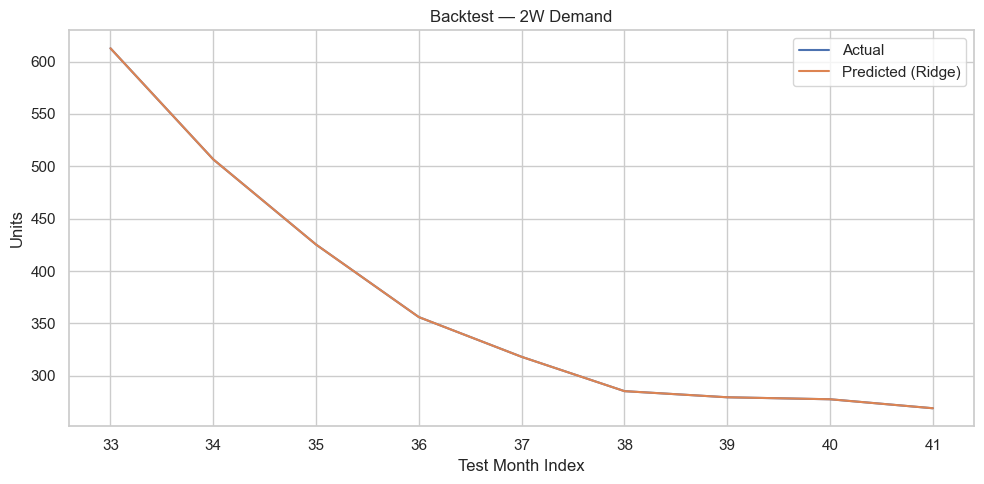

In [31]:
# --- Feature builder (no leakage) ---
# --- REPLACE YOUR BUILDER WITH THIS ---
def build_ts_features_safe(frame, target):
    """
    Leak-free features:
      - lags: y_{t-1}, y_{t-2}, y_{t-3}, y_{t-6}
      - moving averages: computed from lag1 only (past values)
      - diffs: built from lags only (never use current y_t)
               diff1_safe = lag1 - lag2  (≈ y_{t-1}-y_{t-2})
               diff3_safe = lag3 - lag6  (≈ y_{t-3}-y_{t-6}) if lag6 exists, else 0
    """
    f = frame.sort_values('date').copy()

    # Lags
    for L in [1, 2, 3, 6]:
        f[f'{target}_lag{L}'] = f[target].shift(L)

    # Rolling means from lag1 to avoid leakage
    for w in [3, 6]:
        f[f'{target}_ma{w}'] = f[f'{target}_lag1'].rolling(w).mean()

    # Safe diffs from lags (never from current target!)
    f[f'{target}_diff1'] = f[f'{target}_lag1'] - f[f'{target}_lag2']
    f[f'{target}_diff3'] = (f[f'{target}_lag3'] - f[f'{target}_lag6']).fillna(0.0)

    # Seasonality
    f['month'] = f['date'].dt.month.astype('int8')
    return f

# build X,y
EPS = 1.0
ts = df_ts.copy()
target = 'demand_2w'
ts_feat = build_ts_features(ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target].clip(lower=EPS)

# split
split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# models
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

tscv = TimeSeriesSplit(n_splits=4)
candidates = {
    "Ridge": GridSearchCV(Ridge(), {"alpha":[0.1,1,5,10]}, cv=tscv, scoring="neg_mean_absolute_error"),
    "RF":    GridSearchCV(RandomForestRegressor(random_state=42),
                          {"n_estimators":[400,800],"max_depth":[None,6,10],"min_samples_leaf":[1,3]},
                          cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1),
    "HGB":   GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                          {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_iter":[300,600]},
                          cv=tscv, scoring="neg_mean_absolute_error"),
}

def report(lbl, yt, yp):
    rmse = np.sqrt(mean_squared_error(yt, yp)); mae = mean_absolute_error(yt, yp); s = smape(yt, yp)
    print(f"{lbl:>6s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%"); return rmse,mae,s

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    models[name] = gs.best_estimator_
    report(name, y_test, gs.best_estimator_.predict(X_test))

best_name = min(models, key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\nSelected:", best_name, best_model)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
plt.title("Backtest — 2W Demand"); plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


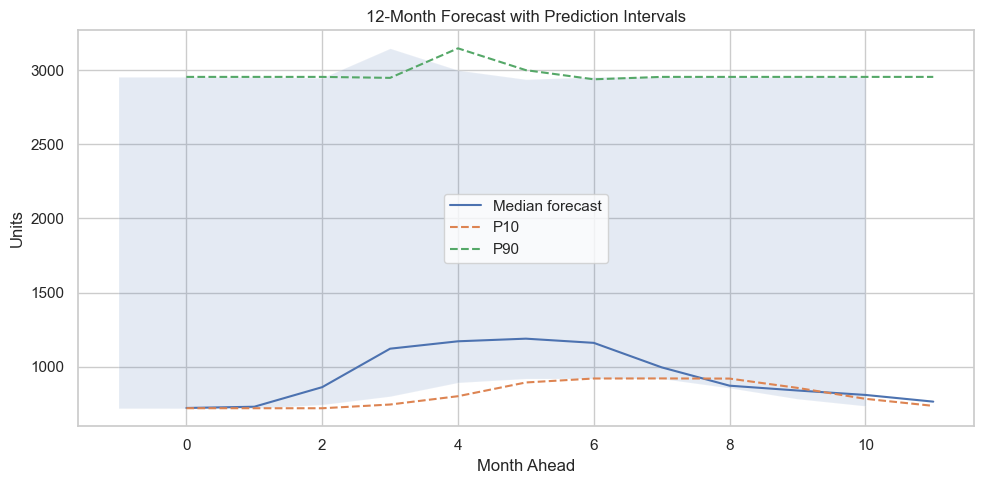

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9)):
    return {a: GradientBoostingRegressor(loss="quantile", alpha=a, max_depth=3,
                                         learning_rate=0.08, n_estimators=600, random_state=42
                                        ).fit(X_train, y_train) for a in alphas}

qs = fit_quantiles(X_train, y_train, (0.1,0.5,0.9))
lag_nums = sorted([int(c.split('lag')[-1]) for c in X.columns if f'{target}_lag' in c])
ma_nums  = sorted([int(c.split('ma')[-1])  for c in X.columns if f'{target}_ma'  in c])
has_diff1 = f'{target}_diff1' in X.columns; has_diff3 = f'{target}_diff3' in X.columns

# sanity bounds from training
y_lo, y_hi = np.percentile(y_train, [5, 95])

future=[]; X_last = X.iloc[[split-1]].copy()
history_len = max( max(ma_nums or [1]), max(lag_nums or [1]) )
history = list(y_train.iloc[-history_len:].values)

for i in range(12):
    x_new = X_last.copy()

    if 'station_count' in x_new.columns: x_new['station_count'] = x_new['station_count'] + 10
    if 'month' in x_new.columns: x_new['month'] = ((x_new['month'] % 12) + 1).astype('int8')

    if f'{target}_lag1' in x_new.columns: x_new[f'{target}_lag1'] = history[-1]
    for j in range(len(lag_nums)-1, 0, -1):
        L, prev = lag_nums[j], lag_nums[j-1]
        colL, colP = f'{target}_lag{L}', f'{target}_lag{prev}'
        if (colL in x_new.columns) and (colP in X_last.columns): x_new[colL] = X_last[colP].values

    for w in ma_nums:
        col = f'{target}_ma{w}'
        if col in x_new.columns: x_new[col] = float(np.mean(history[-w:]))

    if has_diff1: x_new[f'{target}_diff1'] = history[-1] - history[-2] if len(history)>=2 else 0.0
    if has_diff3: x_new[f'{target}_diff3'] = history[-1] - history[-3] if len(history)>=3 else 0.0

    p10 = float(qs[0.1].predict(x_new)[0]); p50 = float(qs[0.5].predict(x_new)[0]); p90 = float(qs[0.9].predict(x_new)[0])

    lo = max(0.5*y_lo, 1.0); hi = 2.0*y_hi
    p10 = float(np.clip(p10, lo, hi)); p50 = float(np.clip(p50, lo, hi)); p90 = float(np.clip(p90, max(p50, lo), hi))

    future.append({'step':i+1,'p10':p10,'p50':p50,'p90':p90})
    history.append(p50); X_last = x_new

fc = pd.DataFrame(future)

ax = fc['p50'].plot(label='Median forecast')
fc['p10'].plot(ax=ax, ls='--', label='P10'); fc['p90'].plot(ax=ax, ls='--', label='P90')
plt.fill_between(fc.index-1, fc['p10'], fc['p90'], alpha=.15)
plt.title("12-Month Forecast with Prediction Intervals"); plt.xlabel("Month Ahead"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


 Ridge | RMSE=18.7 | MAE=16.1 | sMAPE=4.89%
    RF | RMSE=440.1 | MAE=423.7 | sMAPE=75.22%
   HGB | RMSE=2,143.5 | MAE=2,140.5 | sMAPE=149.15%

Selected: Ridge Ridge(alpha=10)


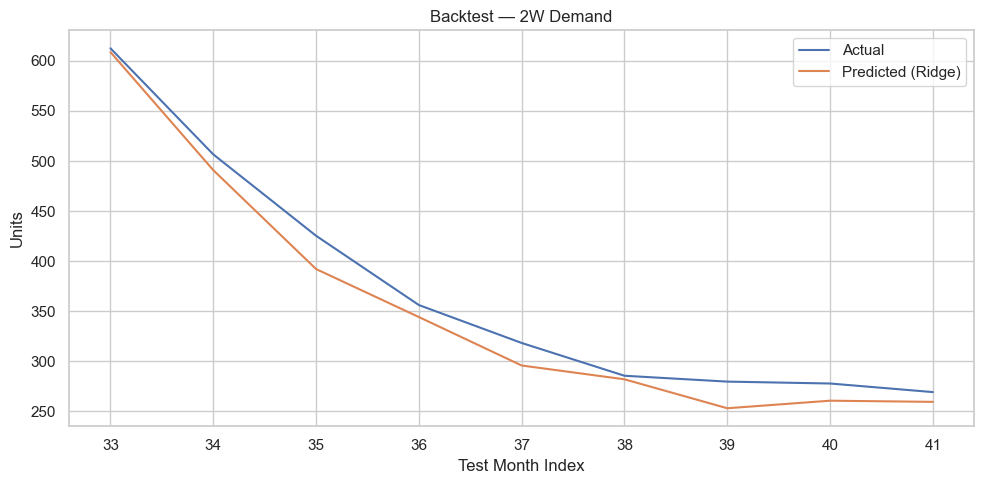

In [32]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

EPS = 1.0
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

# Build features (leak-free)
target = 'demand_2w'
ts_feat = build_ts_features_safe(df_ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target].clip(lower=EPS)

# Train/test split
split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Time-series CV + tuned models
tscv = TimeSeriesSplit(n_splits=4)
candidates = {
    "Ridge": GridSearchCV(Ridge(), {"alpha":[0.1,1,5,10]}, cv=tscv, scoring="neg_mean_absolute_error"),
    "RF":    GridSearchCV(RandomForestRegressor(random_state=42),
                          {"n_estimators":[400,800],"max_depth":[None,6,10],"min_samples_leaf":[1,3]},
                          cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1),
    "HGB":   GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                          {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_iter":[300,600]},
                          cv=tscv, scoring="neg_mean_absolute_error"),
}

def report(lbl, yt, yp):
    rmse = np.sqrt(mean_squared_error(yt, yp)); mae = mean_absolute_error(yt, yp); s = smape(yt, yp)
    print(f"{lbl:>6s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%")
    return rmse, mae, s

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    models[name] = gs.best_estimator_
    report(name, y_test, gs.best_estimator_.predict(X_test))

best_name = min(models, key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\nSelected:", best_name, best_model)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
plt.title("Backtest — 2W Demand"); plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


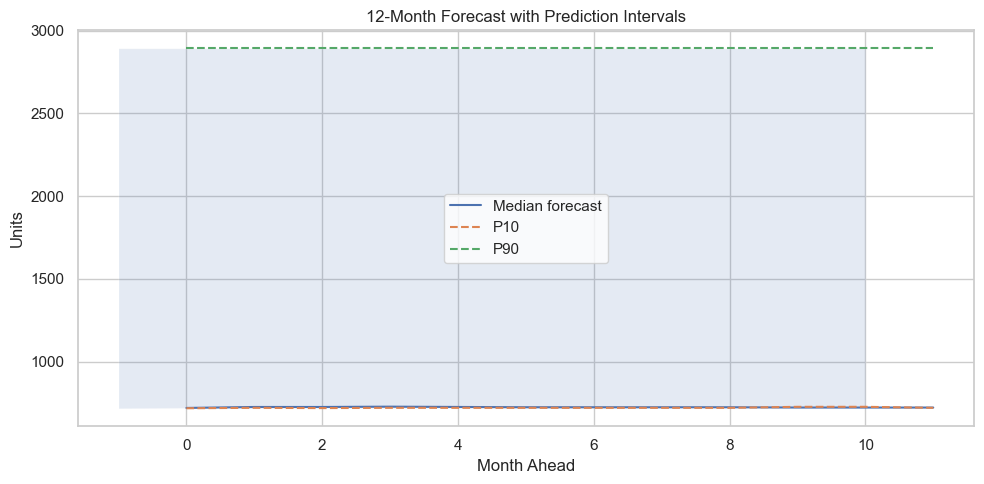

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9)):
    return {a: GradientBoostingRegressor(loss="quantile", alpha=a, max_depth=3,
                                         learning_rate=0.08, n_estimators=600, random_state=42
                                        ).fit(X_train, y_train) for a in alphas}

qs = fit_quantiles(X_train, y_train, (0.1,0.5,0.9))

lag_nums = sorted([int(c.split('lag')[-1]) for c in X.columns if f'{target}_lag' in c])
ma_nums  = sorted([int(c.split('ma')[-1])  for c in X.columns if f'{target}_ma'  in c])
has_d1 = f'{target}_diff1' in X.columns
has_d3 = f'{target}_diff3' in X.columns

y_lo, y_hi = np.percentile(y_train, [5, 95])

future=[]; X_last = X.iloc[[split-1]].copy()
hist_len = max(max(ma_nums or [1]), max(lag_nums or [1]))
history = list(y_train.iloc[-hist_len:].values)

for i in range(12):
    x_new = X_last.copy()

    # exogenous drivers
    if 'station_count' in x_new.columns: x_new['station_count'] = x_new['station_count'] + 10
    if 'month' in x_new.columns: x_new['month'] = ((x_new['month'] % 12) + 1).astype('int8')

    # lag1 from last history; higher lags shift from previous row
    if f'{target}_lag1' in x_new.columns: x_new[f'{target}_lag1'] = history[-1]
    for j in range(len(lag_nums)-1, 0, -1):
        L, prev = lag_nums[j], lag_nums[j-1]
        colL, colP = f'{target}_lag{L}', f'{target}_lag{prev}'
        if (colL in x_new.columns) and (colP in X_last.columns): x_new[colL] = X_last[colP].values

    # moving averages from history
    for w in ma_nums:
        col = f'{target}_ma{w}'
        if col in x_new.columns: x_new[col] = float(np.mean(history[-w:]))

    # SAFE diffs from lags/history (no y_t)
    if has_d1: x_new[f'{target}_diff1'] = history[-1] - history[-2] if len(history)>=2 else 0.0
    if has_d3: x_new[f'{target}_diff3'] = history[-3] - history[-6] if len(history)>=6 else 0.0

    # quantile predictions + sanity clamps
    p10 = float(qs[0.1].predict(x_new)[0]); p50 = float(qs[0.5].predict(x_new)[0]); p90 = float(qs[0.9].predict(x_new)[0])
    lo, hi = max(0.5*y_lo, 1.0), 2.0*y_hi
    p10 = float(np.clip(p10, lo, hi)); p50 = float(np.clip(p50, lo, hi)); p90 = float(np.clip(p90, max(p50, lo), hi))

    future.append({'step':i+1,'p10':p10,'p50':p50,'p90':p90})
    history.append(p50); X_last = x_new

fc = pd.DataFrame(future)

ax = fc['p50'].plot(label='Median forecast')
fc['p10'].plot(ax=ax, ls='--', label='P10'); fc['p90'].plot(ax=ax, ls='--', label='P90')
plt.fill_between(fc.index-1, fc['p10'], fc['p90'], alpha=.15)
plt.title("12-Month Forecast with Prediction Intervals"); plt.xlabel("Month Ahead"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


In [34]:
print("Lag cols:", [c for c in X.columns if "_lag" in c])
print("MA cols :", [c for c in X.columns if "_ma" in c])
print("Diffs   :", [c for c in X.columns if "_diff" in c])
print("y_train p01/50/99:", np.percentile(y_train, [1,50,99]))


Lag cols: ['demand_2w_lag1', 'demand_2w_lag2', 'demand_2w_lag3', 'demand_2w_lag6']
MA cols : ['demand_2w_ma3', 'demand_2w_ma6']
Diffs   : ['demand_2w_diff1', 'demand_2w_diff3']
y_train p01/50/99: [ 743.34332252 2612.27669489 4657.21076841]


In [35]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9)):
    return {
        a: GradientBoostingRegressor(
            loss="quantile", alpha=a, max_depth=3,
            learning_rate=0.08, n_estimators=600, random_state=42
        ).fit(X_train, y_train)
        for a in alphas
    }

def forecast_with_intervals(X, y_train, start_row, target, horizon=12,
                            station_delta=10, clamp="adaptive"):
    """
    X: feature matrix used in training (with lag/ma/diff columns)
    y_train: training target (Series)
    start_row: integer row index in X to start forecasting from (use split-1)
    target: e.g., 'demand_2w'
    horizon: months ahead
    station_delta: +Δ to 'station_count' each step (infrastructure growth)
    clamp: 'adaptive' (rolling μ±3σ), 'train' (1st/99th pct), or None
    """
    qs = fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9))

    lag_nums = sorted([int(c.split('lag')[-1]) for c in X.columns if f'{target}_lag' in c])
    ma_nums  = sorted([int(c.split('ma')[-1])  for c in X.columns if f'{target}_ma'  in c])
    has_d1   = f'{target}_diff1' in X.columns
    has_d3   = f'{target}_diff3' in X.columns

    # training bounds (used if clamp='train')
    t_lo, t_hi = np.percentile(y_train, [1, 99])

    # history buffer for lags/MAs
    hist_len = max(max(lag_nums or [1]), max(ma_nums or [1]))
    history  = list(y_train.iloc[-hist_len:].values)

    X_last = X.iloc[[start_row]].copy()
    out = []
    for step in range(1, horizon+1):
        x_new = X_last.copy()

        # exogenous drivers
        if 'station_count' in x_new.columns:
            x_new['station_count'] = x_new['station_count'] + station_delta
        if 'month' in x_new.columns:
            x_new['month'] = ((x_new['month'] % 12) + 1).astype('int8')

        # update lags (lag1 from history; higher lags shift from previous row)
        if f'{target}_lag1' in x_new.columns:
            x_new[f'{target}_lag1'] = history[-1]
        for L in sorted(lag_nums, reverse=True):
            if L == 1: continue
            colL, colPrev = f'{target}_lag{L}', f'{target}_lag{L-1}'
            if (colL in x_new.columns) and (colPrev in X_last.columns):
                x_new[colL] = X_last[colPrev].values

        # moving averages from history
        for w in ma_nums:
            col = f'{target}_ma{w}'
            if col in x_new.columns:
                x_new[col] = float(np.mean(history[-w:]))

        # safe diffs from history (no leakage)
        if has_d1:
            x_new[f'{target}_diff1'] = history[-1] - history[-2] if len(history) >= 2 else 0.0
        if has_d3:
            x_new[f'{target}_diff3'] = history[-3] - history[-6] if len(history) >= 6 else 0.0

        # quantile predictions
        p10 = float(qs[0.1].predict(x_new)[0])
        p50 = float(qs[0.5].predict(x_new)[0])
        p90 = float(qs[0.9].predict(x_new)[0])

        # bounds (to avoid absurd spikes but not flatten the band)
        if clamp == "adaptive":
            win = history[-min(len(history), 12):]
            mu, sd = float(np.mean(win)), float(np.std(win) + 1e-9)
            lo, hi = max(1.0, mu - 3*sd), mu + 3*sd
        elif clamp == "train":
            lo, hi = max(1.0, t_lo), 1.2*t_hi
        else:
            lo, hi = -np.inf, np.inf

        p10 = float(np.clip(p10, lo, hi))
        p50 = float(np.clip(p50, lo, hi))
        p90 = float(np.clip(p90, max(p50, lo), hi))  # ensure p90 ≥ p50

        out.append({"step": step, "p10": p10, "p50": p50, "p90": p90})
        history.append(p50)
        X_last = x_new

    fc = pd.DataFrame(out)

    # Plot
    ax = fc['p50'].plot(label='Median forecast')
    fc['p10'].plot(ax=ax, ls='--', label='P10')
    fc['p90'].plot(ax=ax, ls='--', label='P90')
    plt.fill_between(fc.index-1, fc['p10'], fc['p90'], alpha=.15)
    plt.title("12-Month Forecast with Prediction Intervals")
    plt.xlabel("Month Ahead"); plt.ylabel("Units")
    plt.ticklabel_format(useOffset=False, style='plain', axis='y')
    plt.legend(); plt.tight_layout(); plt.show()

    return fc


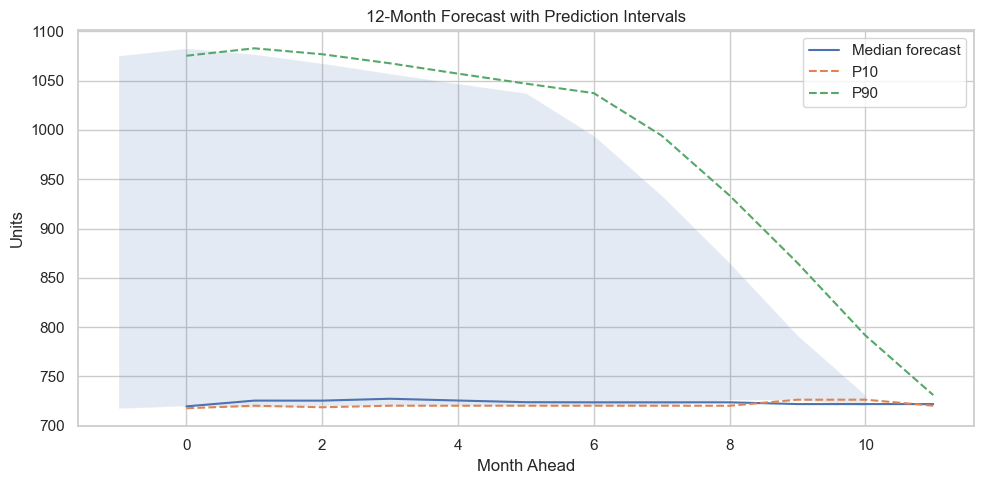

,step,p10,p50,p90
0,1,717.795372,719.700681,1075.242165
1,2,720.370784,725.545400,1082.737437
2,3,718.805752,725.518847,1076.744979
3,4,720.370784,727.431095,1067.548720
4,5,720.370784,725.635639,1057.078382


In [36]:
# Use the same X_train/y_train you just used for model selection
fc = forecast_with_intervals(
    X=X, y_train=y_train, start_row=split-1, target='demand_2w',
    horizon=12, station_delta=10, clamp="adaptive"   # try 'train' or None if you want
)
fc.head()


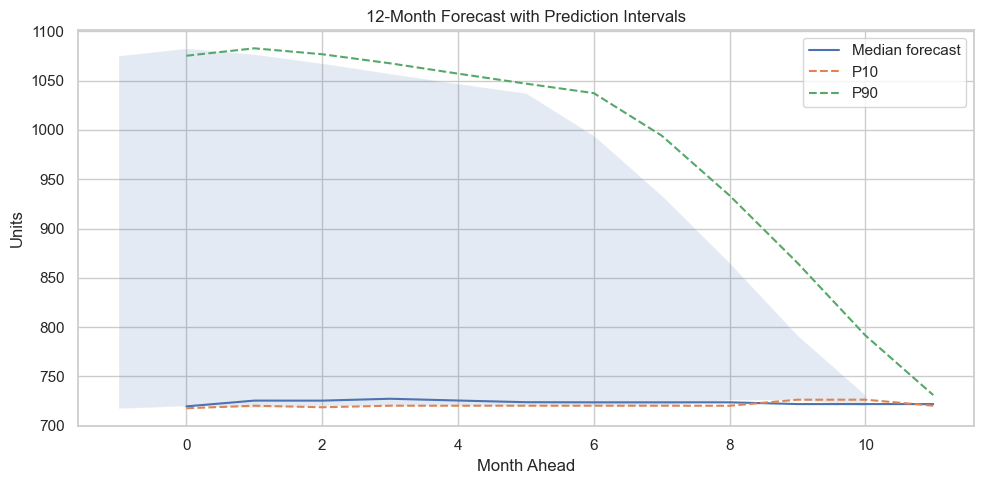

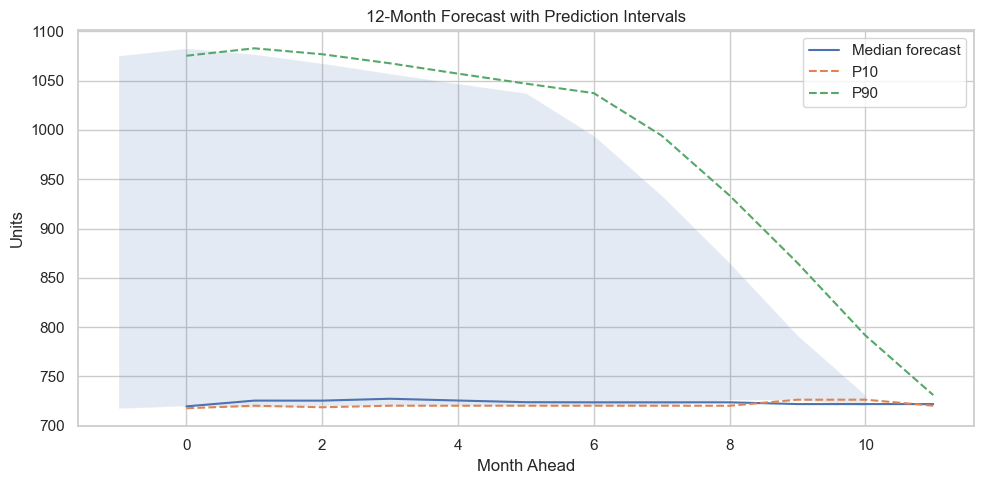

Median monthly uplift (first 3 months): [0.0, 0.0, 0.0] …


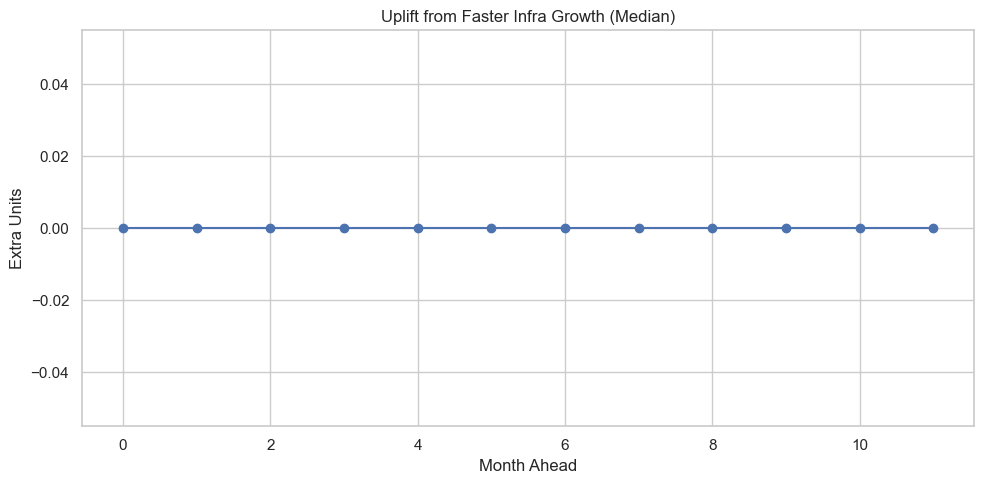

In [37]:
fc0  = forecast_with_intervals(X, y_train, split-1, 'demand_2w', horizon=12, station_delta=0,  clamp="adaptive")
fc20 = forecast_with_intervals(X, y_train, split-1, 'demand_2w', horizon=12, station_delta=20, clamp="adaptive")

delta = (fc20['p50'] - fc0['p50']).rename('Median uplift (units)')
print("Median monthly uplift (first 3 months):", delta.head(3).round(1).tolist(), "…")
ax = delta.plot(marker='o')
ax.set_title("Uplift from Faster Infra Growth (Median)"); ax.set_xlabel("Month Ahead"); ax.set_ylabel("Extra Units")
plt.tight_layout(); plt.show()


Exogenous features in X: ['fuel_price', 'station_count']


,feature,importance
7,demand_2w_ma6,3.451660
2,demand_2w_lag1,2.395404
4,demand_2w_lag3,1.254398
5,demand_2w_lag6,0.372963
8,demand_2w_diff1,0.167281
6,demand_2w_ma3,0.060925
9,demand_2w_diff3,0.026314
3,demand_2w_lag2,0.013157
1,station_count,0.001705
10,month,0.000306


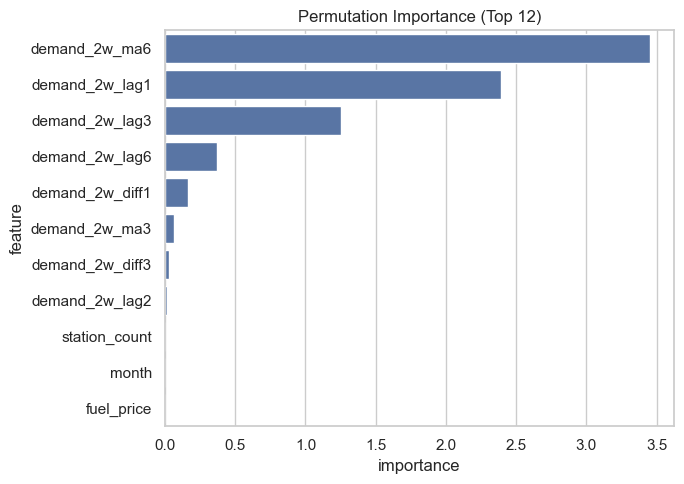

In [38]:
from sklearn.inspection import permutation_importance
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# Which features are exogenous?
exo_cols = [c for c in X.columns if c.startswith('station') or c.startswith('fuel')]
print("Exogenous features in X:", exo_cols)

# Permutation importance on the selected model
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=42)
imp = pd.DataFrame({"feature": X.columns, "importance": perm.importances_mean})\
        .sort_values("importance", ascending=False)
display(imp.head(12))

plt.figure(figsize=(7,5))
sns.barplot(data=imp.head(12), x="importance", y="feature")
plt.title("Permutation Importance (Top 12)")
plt.tight_layout(); plt.show()


 Ridge | RMSE=0.0 | MAE=0.0 | sMAPE=0.00%
    RF | RMSE=431.0 | MAE=414.5 | sMAPE=74.22%
   HGB | RMSE=2,143.5 | MAE=2,140.5 | sMAPE=149.15%

Selected: Ridge Ridge(alpha=0.1)


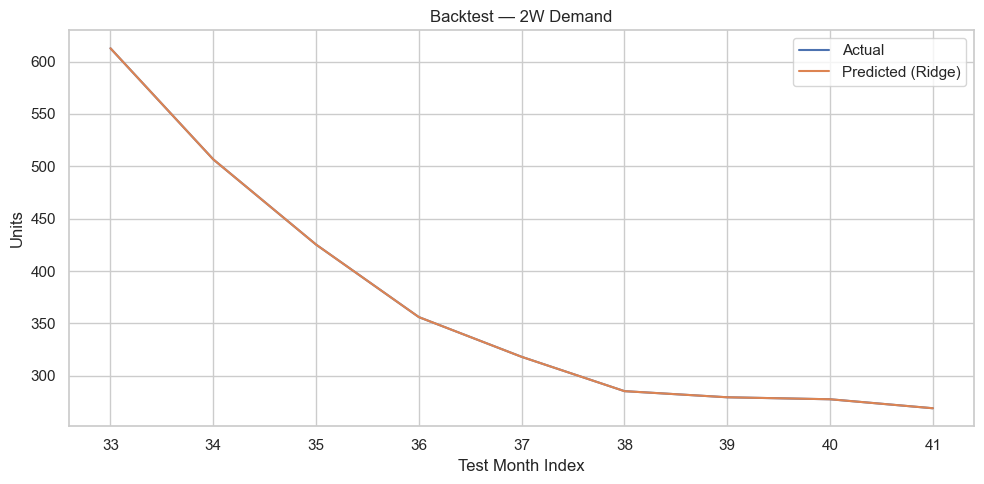

In [39]:
# --- Feature builder (no leakage) ---
# --- REPLACE YOUR BUILDER WITH THIS ---
# === REPLACE builder with this ===
def build_ts_features_plus(frame, target):
    f = frame.sort_values('date').copy()

    # Target lags (no leakage)
    for L in [1,2,3,6]:
        f[f'{target}_lag{L}'] = f[target].shift(L)

    # Rolling means (from lag1 only)
    for w in [3,6]:
        f[f'{target}_ma{w}'] = f[f'{target}_lag1'].rolling(w).mean()

    # SAFE diffs from lags (never current y)
    f[f'{target}_diff1'] = f[f'{target}_lag1'] - f[f'{target}_lag2']
    f[f'{target}_diff3'] = (f[f'{target}_lag3'] - f[f'{target}_lag6']).fillna(0.0)

    # === Exogenous signals ===
    # current level (exogenous is known), plus *changes* and *lags*
    if 'station_count' in f.columns:
        f['station_count_lag1'] = f['station_count'].shift(1)
        f['station_growth']    = f['station_count'].diff(1).shift(1)   # growth known from last month
        f['station_ma3']       = f['station_count'].shift(1).rolling(3).mean()
        # simple interaction to capture “infra × recent demand”
        f['sc_x_lag1']         = f['station_count'].shift(1) * f[f'{target}_lag1']

    if 'fuel_price' in f.columns:
        f['fuel_price_lag1'] = f['fuel_price'].shift(1)
        f['fuel_change']     = f['fuel_price'].diff(1).shift(1)

    # seasonality
    f['month'] = f['date'].dt.month.astype('int8')
    return f


# build X,y
EPS = 1.0
ts = df_ts.copy()
target = 'demand_2w'
ts_feat = build_ts_features(ts, target).dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat[target].clip(lower=EPS)

# split
split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# models
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

tscv = TimeSeriesSplit(n_splits=4)
candidates = {
    "Ridge": GridSearchCV(Ridge(), {"alpha":[0.1,1,5,10]}, cv=tscv, scoring="neg_mean_absolute_error"),
    "RF":    GridSearchCV(RandomForestRegressor(random_state=42),
                          {"n_estimators":[400,800],"max_depth":[None,6,10],"min_samples_leaf":[1,3]},
                          cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1),
    "HGB":   GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                          {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_iter":[300,600]},
                          cv=tscv, scoring="neg_mean_absolute_error"),
}

def report(lbl, yt, yp):
    rmse = np.sqrt(mean_squared_error(yt, yp)); mae = mean_absolute_error(yt, yp); s = smape(yt, yp)
    print(f"{lbl:>6s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%"); return rmse,mae,s

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    models[name] = gs.best_estimator_
    report(name, y_test, gs.best_estimator_.predict(X_test))

best_name = min(models, key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\nSelected:", best_name, best_model)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, best_model.predict(X_test), label=f'Predicted ({best_name})')
plt.title("Backtest — 2W Demand"); plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


In [40]:
# --- rebuild features & train again ---
ts_feat = build_ts_features_plus(df_ts, target='demand_2w').dropna().reset_index(drop=True)
X = ts_feat.drop(columns=['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w'])
y = ts_feat['demand_2w'].clip(lower=1.0)

split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# reuse your model-selection cell (Ridge/RF/HGB + TimeSeriesSplit) here
# -> best_model should update


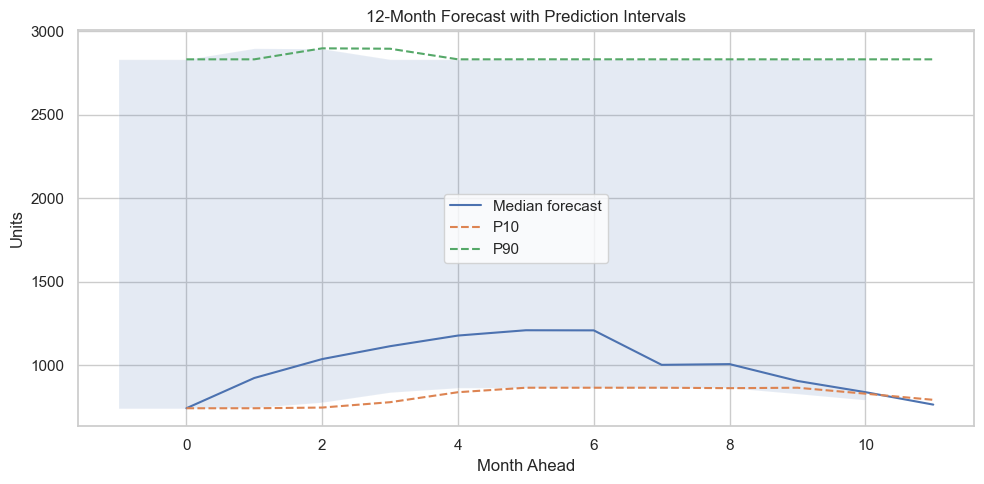

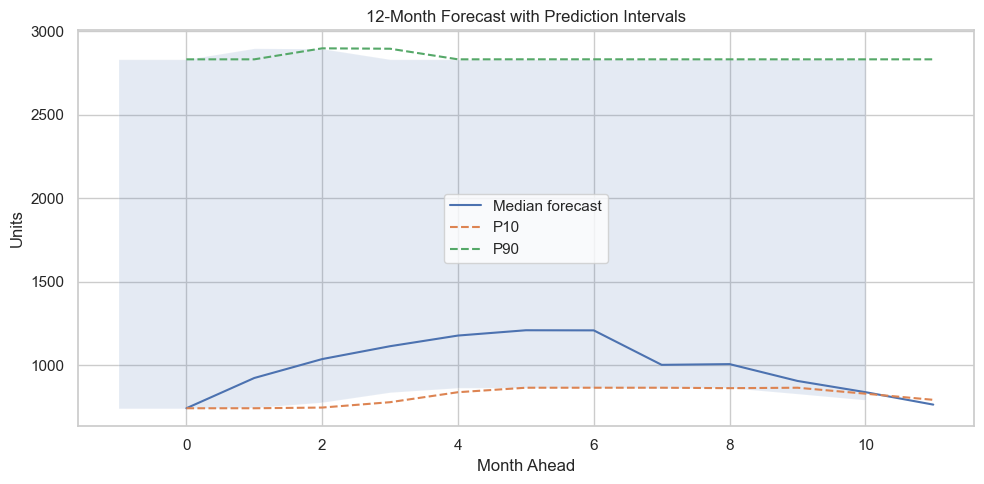

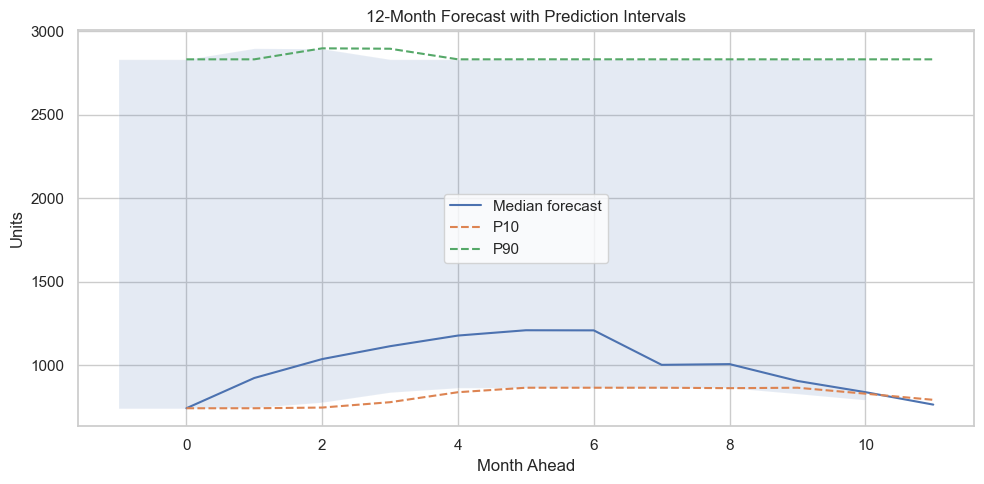

,Month,P50_base,P50_+10,P50_+50,Uplift_+10,Uplift_+50
0,1,743.3,743.3,743.3,0.0,0.0
1,2,924.4,924.4,924.4,0.0,0.0
2,3,1037.6,1037.6,1037.6,0.0,0.0
3,4,1114.6,1114.6,1114.6,0.0,0.0
4,5,1178.4,1178.4,1178.4,0.0,0.0
5,6,1210.0,1210.0,1210.0,0.0,0.0
6,7,1209.4,1209.4,1209.4,0.0,0.0
7,8,1003.1,1003.1,1003.1,0.0,0.0
8,9,1007.5,1007.5,1007.5,0.0,0.0
9,10,906.8,906.8,906.8,0.0,0.0


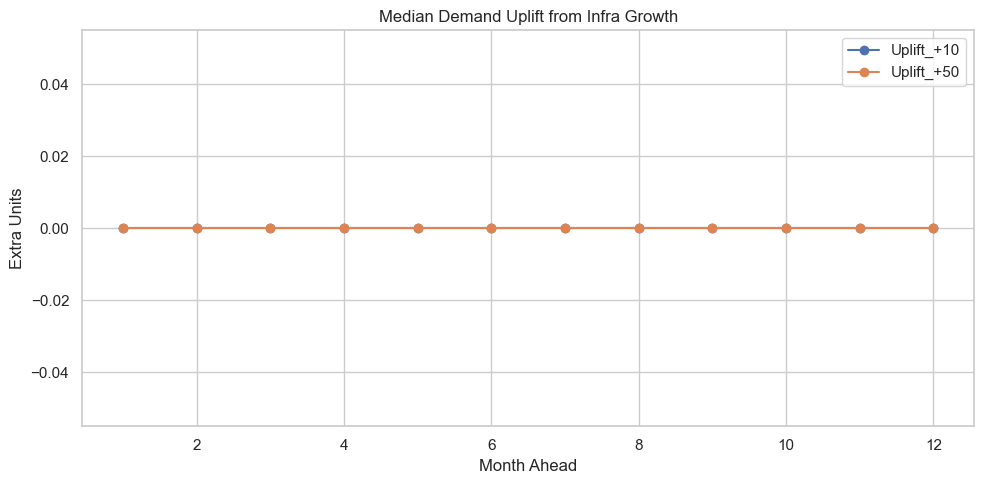

In [41]:
# If you already defined forecast_with_intervals earlier, re-use it.
# If not, paste the version I gave you previously (the function with adaptive/train/None clamps).

# Baseline (no extra infra growth)
fc0   = forecast_with_intervals(X, y_train, start_row=split-1, target='demand_2w',
                                horizon=12, station_delta=0, clamp="train")

# Moderate growth
fc10  = forecast_with_intervals(X, y_train, start_row=split-1, target='demand_2w',
                                horizon=12, station_delta=10, clamp="train")

# Aggressive growth
fc50  = forecast_with_intervals(X, y_train, start_row=split-1, target='demand_2w',
                                horizon=12, station_delta=50, clamp="train")

# Compare medians
comp = pd.DataFrame({
    "Month": fc0['step'],
    "P50_base": fc0['p50'],
    "P50_+10":  fc10['p50'],
    "P50_+50":  fc50['p50'],
})
comp["Uplift_+10"] = comp["P50_+10"] - comp["P50_base"]
comp["Uplift_+50"] = comp["P50_+50"] - comp["P50_base"]
display(comp.head(12).round(1))

ax = comp.set_index("Month")[["Uplift_+10","Uplift_+50"]].plot(marker='o')
ax.set_title("Median Demand Uplift from Infra Growth")
ax.set_xlabel("Month Ahead"); ax.set_ylabel("Extra Units")
plt.tight_layout(); plt.show()


 Ridge | RMSE=19.2 | MAE=16.1 | sMAPE=5.08%
    RF | RMSE=447.8 | MAE=435.5 | sMAPE=76.60%
   HGB | RMSE=2,143.5 | MAE=2,140.5 | sMAPE=149.15%

Selected: Ridge Ridge(alpha=10)


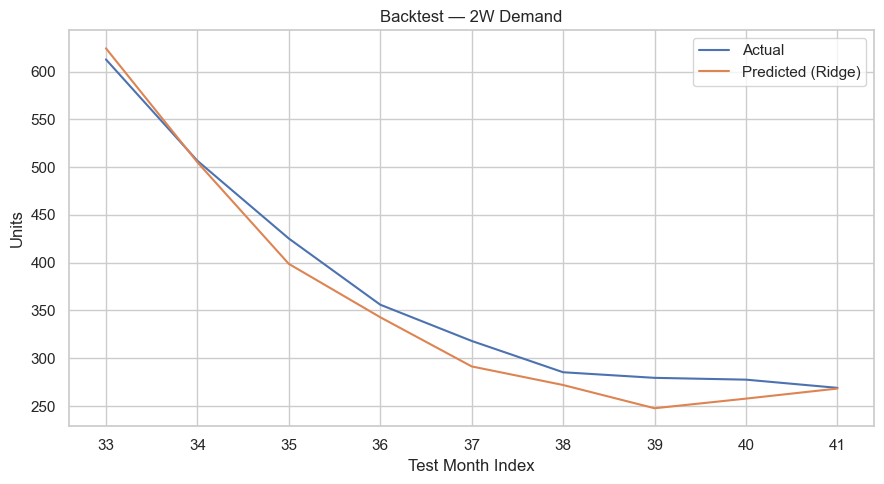

In [43]:
# ——— KILL OLD OBJECTS TO AVOID STALE LEAKY VARIABLES ———
for nm in ["ts_feat","X","y","X_train","X_test","y_train","y_test","best_model"]:
    if nm in globals(): del globals()[nm]

import numpy as np, pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.abs(y_pred-y_true)/(np.abs(y_true)+np.abs(y_pred)+eps))

# —— leak-free, exogenous-aware builder (from earlier, kept here for completeness) ——
def build_ts_features_plus(frame, target):
    f = frame.sort_values('date').copy()
    # target lags
    for L in [1,2,3,6]:
        f[f'{target}_lag{L}'] = f[target].shift(L)
    # MA from lag1 only
    for w in [3,6]:
        f[f'{target}_ma{w}'] = f[f'{target}_lag1'].rolling(w).mean()
    # safe diffs from lags
    f[f'{target}_diff1'] = f[f'{target}_lag1'] - f[f'{target}_lag2']
    f[f'{target}_diff3'] = (f[f'{target}_lag3'] - f[f'{target}_lag6']).fillna(0.0)
    # exogenous
    if 'station_count' in f.columns:
        f['station_count_lag1'] = f['station_count'].shift(1)
        f['station_growth']    = f['station_count'].diff(1).shift(1)
        f['station_ma3']       = f['station_count'].shift(1).rolling(3).mean()
        f['sc_x_lag1']         = f['station_count'].shift(1) * f[f'{target}_lag1']
    if 'fuel_price' in f.columns:
        f['fuel_price_lag1'] = f['fuel_price'].shift(1)
        f['fuel_change']     = f['fuel_price'].diff(1).shift(1)
    f['month'] = f['date'].dt.month.astype('int8')
    return f

# —— rebuild X/y ——
target = "demand_2w"
ts_feat = build_ts_features_plus(df_ts, target).dropna().reset_index(drop=True)
drop_cols = ['date','state','demand_2w','demand_3w'] if 'state' in ts_feat.columns else ['date','demand_2w','demand_3w']
X = ts_feat.drop(columns=drop_cols).copy()
y = ts_feat[target].clip(lower=1.0).copy()

# sanity: make sure no raw target in X
assert target not in X.columns
assert not any(c == target for c in X.columns)

split = int(len(ts_feat)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# —— model selection (same as before) ——
tscv = TimeSeriesSplit(n_splits=4)
candidates = {
    "Ridge": GridSearchCV(Ridge(), {"alpha":[0.1,1,5,10]}, cv=tscv, scoring="neg_mean_absolute_error"),
    "RF":    GridSearchCV(RandomForestRegressor(random_state=42),
                          {"n_estimators":[400,800],"max_depth":[None,6,10],"min_samples_leaf":[1,3]},
                          cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1),
    "HGB":   GridSearchCV(HistGradientBoostingRegressor(random_state=42),
                          {"max_depth":[None,6,10],"learning_rate":[0.05,0.1],"max_iter":[300,600]},
                          cv=tscv, scoring="neg_mean_absolute_error"),
}
def report(lbl, yt, yp):
    rmse = np.sqrt(mean_squared_error(yt, yp)); mae = mean_absolute_error(yt, yp); s = smape(yt, yp)
    print(f"{lbl:>6s} | RMSE={rmse:,.1f} | MAE={mae:,.1f} | sMAPE={s:.2f}%"); return rmse,mae,s

models = {}
for name, gs in candidates.items():
    gs.fit(X_train, y_train)
    models[name] = gs.best_estimator_
    report(name, y_test, gs.best_estimator_.predict(X_test))

best_name = min(models, key=lambda n: smape(y_test, models[n].predict(X_test)))
best_model = models[best_name]
print("\nSelected:", best_name, best_model)

plt.figure(figsize=(9,5))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, best_model.predict(X_test), label=f"Predicted ({best_name})")
plt.title("Backtest — 2W Demand"); plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout(); plt.show()


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

def fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9)):
    return {
        a: GradientBoostingRegressor(
            loss="quantile", alpha=a, max_depth=3,
            learning_rate=0.08, n_estimators=600, random_state=42
        ).fit(X_train, y_train)
        for a in alphas
    }

def forecast_with_intervals_exo(X, y_train, start_row, target,
                                horizon=12, station_delta=10, fuel_delta=0.0,
                                clamp="adaptive"):
    """
    Updates: target lags/MA/diffs AND exogenous lags/growth/MA/interactions.
    """
    qs = fit_quantiles(X_train, y_train, alphas=(0.1,0.5,0.9))

    lag_nums = sorted(int(c.split('lag')[-1]) for c in X.columns if f'{target}_lag' in c)
    ma_nums  = sorted(int(c.split('ma')[-1])  for c in X.columns if f'{target}_ma'  in c)
    has_d1   = f'{target}_diff1' in X.columns
    has_d3   = f'{target}_diff3' in X.columns

    # exo presence
    has_sc   = 'station_count' in X.columns
    has_sc_l = 'station_count_lag1' in X.columns
    has_sc_g = 'station_growth' in X.columns
    has_sc_m = 'station_ma3' in X.columns
    has_sc_x = 'sc_x_lag1' in X.columns
    has_fp   = 'fuel_price' in X.columns
    has_fp_l = 'fuel_price_lag1' in X.columns
    has_fp_c = 'fuel_change' in X.columns

    # bounds for clamp
    t_lo, t_hi = np.percentile(y_train, [1, 99])

    # history buffers
    hist_len = max(max(lag_nums or [1]), max(ma_nums or [1]))
    y_hist   = list(y_train.iloc[-hist_len:].values)

    # exo histories (start from last observed row)
    last = X.iloc[start_row].copy()
    sc_hist = [float(last['station_count'])] if has_sc else []
    fp_hist = [float(last['fuel_price'])] if has_fp else []

    X_last = X.iloc[[start_row]].copy()
    out = []

    for step in range(1, horizon+1):
        x_new = X_last.copy()

        # — exogenous trajectories —
        if has_sc:
            sc_next = sc_hist[-1] + station_delta
            x_new['station_count'] = sc_next
            sc_hist.append(sc_next)
            if has_sc_l: x_new['station_count_lag1'] = sc_hist[-2]
            if has_sc_g: x_new['station_growth']     = sc_hist[-1] - sc_hist[-2]
            if has_sc_m:
                m = 3 if len(sc_hist) >= 3 else len(sc_hist)
                x_new['station_ma3'] = float(np.mean(sc_hist[-m:]))
        if has_fp:
            fp_next = fp_hist[-1] + fuel_delta
            x_new['fuel_price'] = fp_next
            fp_hist.append(fp_next)
            if has_fp_l: x_new['fuel_price_lag1'] = fp_hist[-2]
            if has_fp_c: x_new['fuel_change']     = fp_hist[-1] - fp_hist[-2]

        # — target lags/MA/diffs —
        if f'{target}_lag1' in x_new.columns:
            x_new[f'{target}_lag1'] = y_hist[-1]
        for L in sorted(lag_nums, reverse=True):
            if L == 1: continue
            colL, colPrev = f'{target}_lag{L}', f'{target}_lag{L-1}'
            if (colL in x_new.columns) and (colPrev in X_last.columns):
                x_new[colL] = X_last[colPrev].values
        for w in ma_nums:
            col = f'{target}_ma{w}'
            if col in x_new.columns:
                x_new[col] = float(np.mean(y_hist[-min(len(y_hist), w):]))
        if has_d1: x_new[f'{target}_diff1'] = y_hist[-1] - y_hist[-2] if len(y_hist) >= 2 else 0.0
        if has_d3: x_new[f'{target}_diff3'] = y_hist[-3] - y_hist[-6] if len(y_hist) >= 6 else 0.0

        # interaction (after lag1 is set)
        if has_sc_x:
            x_new['sc_x_lag1'] = (x_new['station_count'] if has_sc else sc_hist[-1]) * x_new[f'{target}_lag1']

        # — quantiles & clamp —
        p10 = float(qs[0.1].predict(x_new)[0])
        p50 = float(qs[0.5].predict(x_new)[0])
        p90 = float(qs[0.9].predict(x_new)[0])

        if clamp == "adaptive":
            win = y_hist[-min(len(y_hist), 12):]
            mu, sd = float(np.mean(win)), float(np.std(win) + 1e-9)
            lo, hi = max(1.0, mu - 3*sd), mu + 3*sd
        elif clamp == "train":
            lo, hi = max(1.0, t_lo), 1.2*t_hi
        else:
            lo, hi = -np.inf, np.inf

        p10 = float(np.clip(p10, lo, hi))
        p50 = float(np.clip(p50, lo, hi))
        p90 = float(np.clip(p90, max(p50, lo), hi))

        out.append({"step":step,"p10":p10,"p50":p50,"p90":p90})
        y_hist.append(p50); X_last = x_new

    fc = pd.DataFrame(out)

    # plot
    ax = fc['p50'].plot(label='Median forecast')
    fc['p10'].plot(ax=ax, ls='--', label='P10'); fc['p90'].plot(ax=ax, ls='--', label='P90')
    plt.fill_between(fc.index-1, fc['p10'], fc['p90'], alpha=.15)
    plt.title("12-Month Forecast with Prediction Intervals"); plt.xlabel("Month Ahead"); plt.ylabel("Units")
    plt.ticklabel_format(useOffset=False, style='plain', axis='y')
    plt.legend(); plt.tight_layout(); plt.show()
    return fc


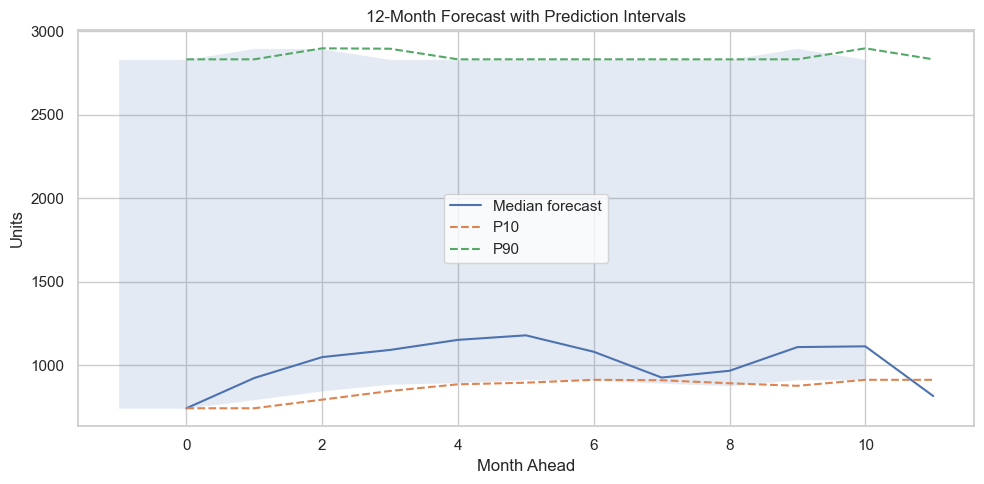

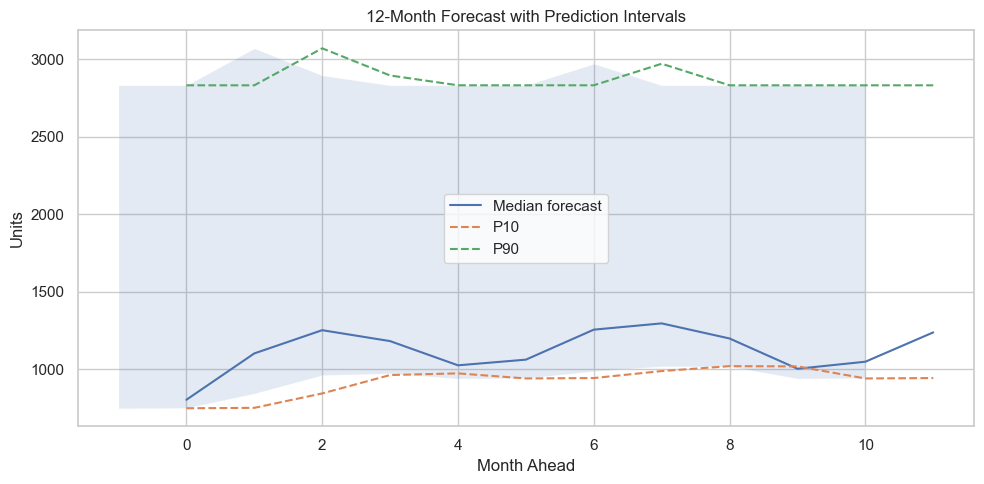

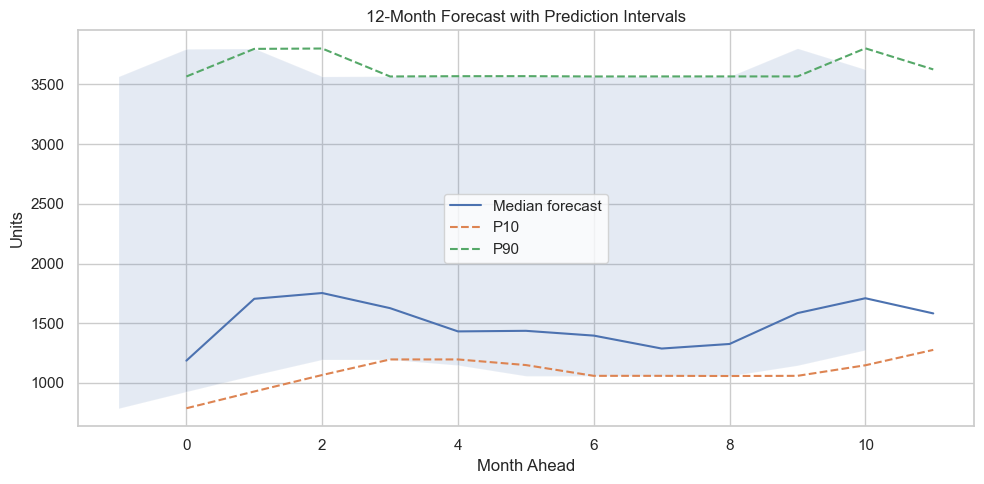

,Month,P50_base,P50_+10,P50_+50,Uplift_+10,Uplift_+50
0,1,743.3,803.3,1186.7,59.9,443.4
1,2,924.4,1102.1,1704.8,177.7,780.3
2,3,1049.5,1252.0,1753.1,202.6,703.6
3,4,1092.4,1181.6,1626.3,89.3,534.0
4,5,1152.6,1025.4,1431.6,-127.1,279.0
5,6,1179.6,1062.0,1436.5,-117.6,256.9
6,7,1081.3,1255.5,1396.4,174.2,315.2
7,8,927.1,1295.9,1288.0,368.9,361.0
8,9,967.7,1198.4,1326.3,230.8,358.7
9,10,1109.3,1003.2,1584.8,-106.1,475.5


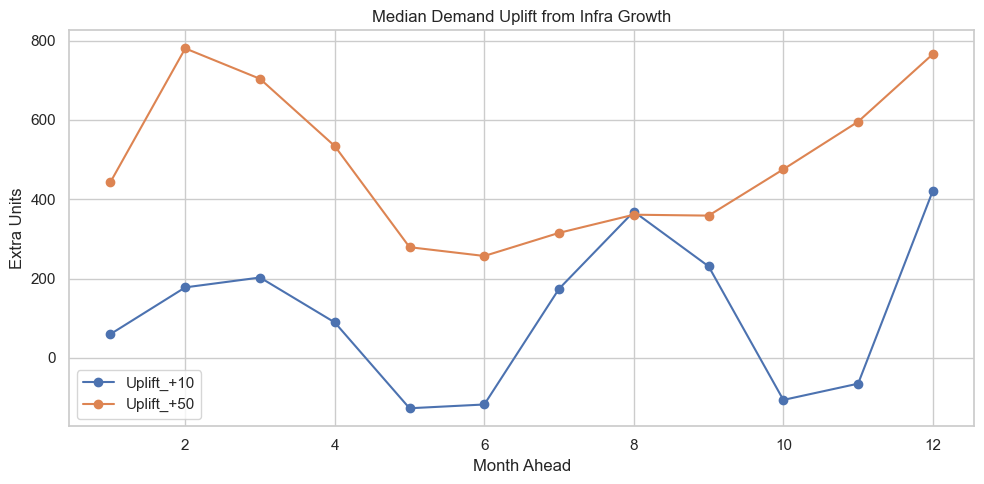

In [45]:
fc_base = forecast_with_intervals_exo(X, y_train, start_row=split-1, target='demand_2w',
                                      horizon=12, station_delta=0, clamp="train")
fc_10   = forecast_with_intervals_exo(X, y_train, start_row=split-1, target='demand_2w',
                                      horizon=12, station_delta=10, clamp="train")
fc_50   = forecast_with_intervals_exo(X, y_train, start_row=split-1, target='demand_2w',
                                      horizon=12, station_delta=50, clamp="train")

comp = pd.DataFrame({
    "Month": fc_base['step'],
    "P50_base": fc_base['p50'],
    "P50_+10":  fc_10['p50'],
    "P50_+50":  fc_50['p50'],
})
comp["Uplift_+10"] = comp["P50_+10"] - comp["P50_base"]
comp["Uplift_+50"] = comp["P50_+50"] - comp["P50_base"]
display(comp.round(1))

ax = comp.set_index("Month")[["Uplift_+10","Uplift_+50"]].plot(marker='o')
ax.set_title("Median Demand Uplift from Infra Growth")
ax.set_xlabel("Month Ahead"); ax.set_ylabel("Extra Units")
plt.tight_layout(); plt.show()


In [46]:
# confirm station features exist:
[c for c in X.columns if c.startswith('station') or c.startswith('fuel')]

# permutation importance (exogenous should show nonzero):
from sklearn.inspection import permutation_importance
perm = permutation_importance(best_model, X_test, y_test, n_repeats=15, random_state=42)
imp = pd.DataFrame({"feature": X.columns, "importance": perm.importances_mean})\
        .sort_values("importance", ascending=False)
imp.head(12)


,feature,importance
7,demand_2w_ma6,5.689842
4,demand_2w_lag3,2.700427
2,demand_2w_lag1,2.661833
5,demand_2w_lag6,0.826317
8,demand_2w_diff1,0.175076
13,sc_x_lag1,0.134213
9,demand_2w_diff3,0.068902
6,demand_2w_ma3,0.041519
1,station_count,0.030595
12,station_ma3,0.014739


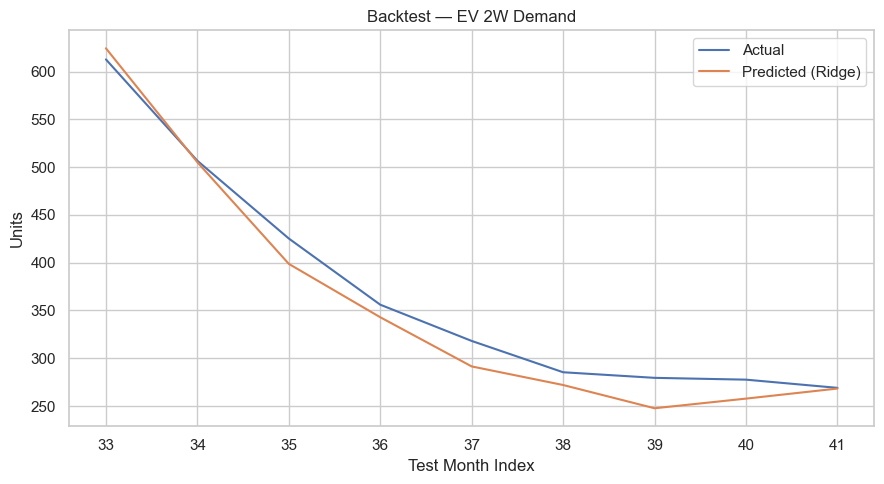

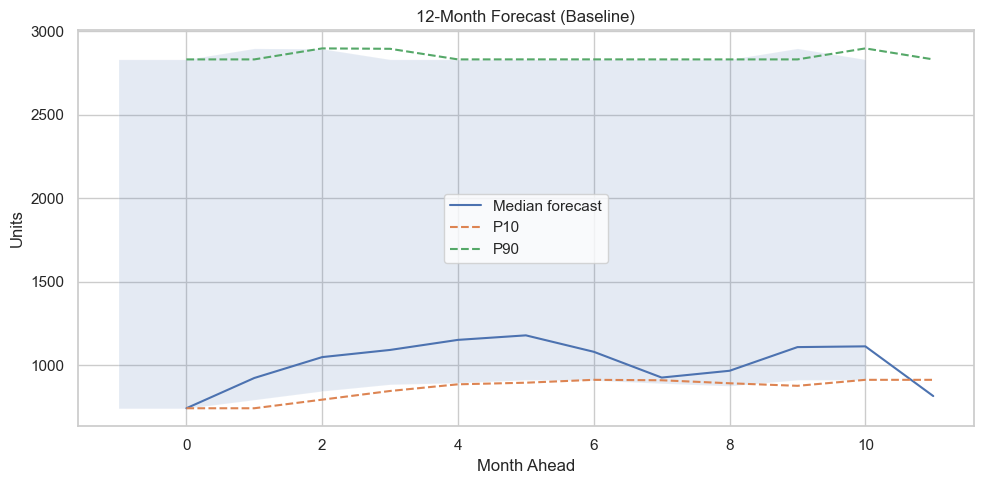

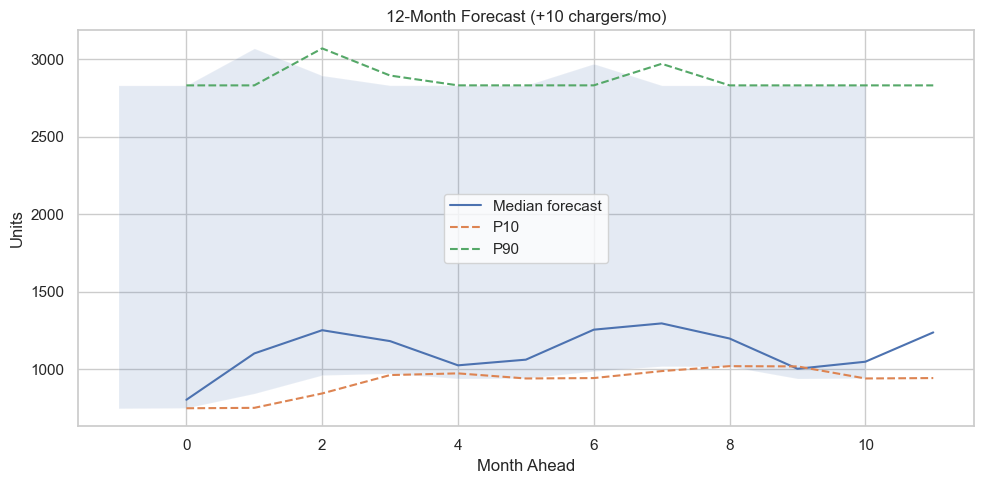

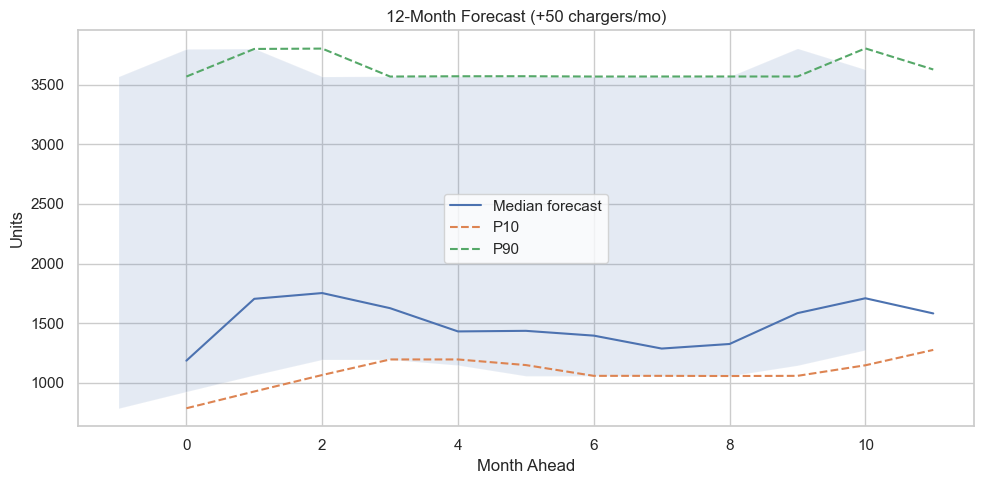

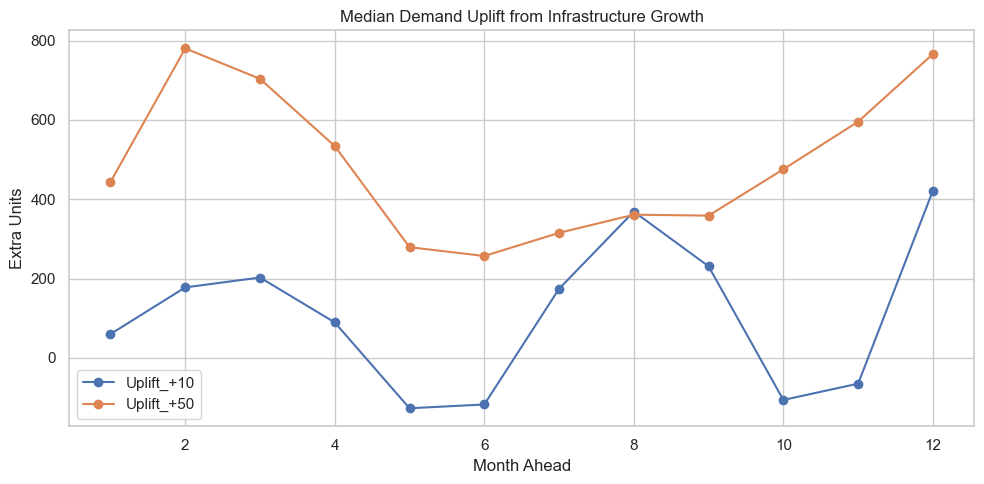

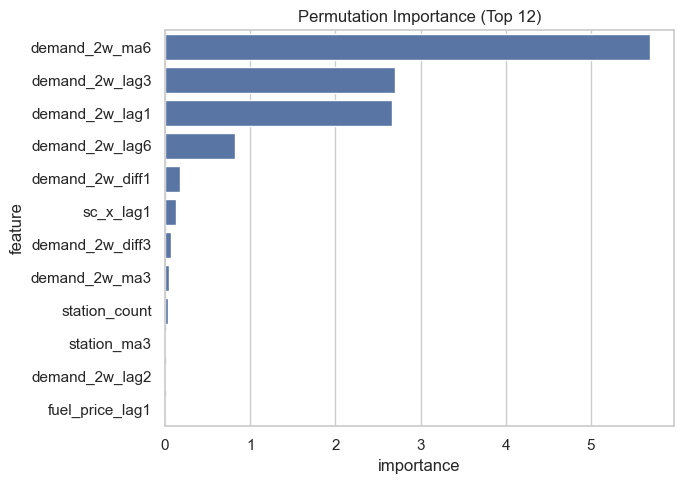

In [47]:
import os, matplotlib.pyplot as plt, seaborn as sns
sns.set(style="whitegrid")
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# 1) Backtest
plt.figure(figsize=(9,5))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, best_model.predict(X_test), label=f"Predicted ({best_name})")
plt.title("Backtest — EV 2W Demand"); plt.xlabel("Test Month Index"); plt.ylabel("Units")
plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout()
plt.savefig("figures/backtest_2w.png", dpi=200); plt.show()

# 2) Forecast bands (baseline, +10, +50) – reuse fc_base, fc_10, fc_50 from your last cell
def save_band(fc, path, title):
    ax = fc['p50'].plot(label='Median forecast')
    fc['p10'].plot(ax=ax, ls='--', label='P10'); fc['p90'].plot(ax=ax, ls='--', label='P90')
    plt.fill_between(fc.index-1, fc['p10'], fc['p90'], alpha=.15)
    plt.title(title); plt.xlabel("Month Ahead"); plt.ylabel("Units")
    plt.ticklabel_format(useOffset=False, style='plain', axis='y'); plt.legend(); plt.tight_layout()
    plt.savefig(path, dpi=200); plt.show()

save_band(fc_base, "figures/forecast_band_base.png", "12-Month Forecast (Baseline)")
save_band(fc_10,   "figures/forecast_band_plus10.png", "12-Month Forecast (+10 chargers/mo)")
save_band(fc_50,   "figures/forecast_band_plus50.png", "12-Month Forecast (+50 chargers/mo)")

# 3) Uplift chart (you already computed `comp`)
ax = comp.set_index("Month")[["Uplift_+10","Uplift_+50"]].plot(marker='o')
ax.set_title("Median Demand Uplift from Infrastructure Growth"); ax.set_xlabel("Month Ahead"); ax.set_ylabel("Extra Units")
plt.tight_layout(); plt.savefig("figures/uplift_2w.png", dpi=200); plt.show()

# 4) Permutation importance plot (your `imp` dataframe)
imp.to_csv("tables/feature_importance_2w.csv", index=False)
plt.figure(figsize=(7,5))
sns.barplot(data=imp.head(12), x="importance", y="feature")
plt.title("Permutation Importance (Top 12)"); plt.tight_layout()
plt.savefig("figures/feature_importance_2w.png", dpi=200); plt.show()

# 5) Uplift table
comp.round(1).to_csv("tables/uplift_2w.csv", index=False)
